# Plot figures from the paper
Running this notebook sequentially will create all figures in the main part and appendix of the paper.

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import numpy as np


from sklearn.metrics import mean_squared_error
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error, max_error, mean_absolute_percentage_error

import math

from sklearn.preprocessing import PowerTransformer
import h5py
from keras.models import load_model

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
text_width = 6.96

def setup_matplotlib(small_size: int = SMALL_SIZE, medium_size: int = MEDIUM_SIZE):
    # Set desired font sizes for text in figures
    plt.rcParams.update({
        'font.size': small_size,
        'axes.titlesize': medium_size,
        'axes.labelsize': medium_size,
        'xtick.labelsize': medium_size,
        'ytick.labelsize': medium_size,
        'legend.fontsize': medium_size,
        'figure.titlesize': medium_size,
})
    
def setup_matplotlib_latex():
    # Use LaTeX to typeset all text in the figure
    # This obviously needs a working LaTeX installation on the system
    plt.rcParams.update({
        'font.family': 'serif',
        'text.usetex': True,
        'mathtext.fontset': 'cm',
        'mathtext.rm': 'serif',
        'text.latex.preamble': '\\usepackage{amsmath}\n'
                               '\\usepackage{amssymb}'
})

setup_matplotlib()
# Please comment the following line if you do not have LaTeX installed on your system
setup_matplotlib_latex()

In [2]:
df = pd.read_excel('../data/database_new.xlsx')

In [3]:
parameters=[{'alpha':[0.0001, 0.001, 0.01, 0.05, 0.1, 0.5,1],
            'kernel':['rbf'],
            'gamma':[0, 0.0001, 0.001, 0.01,0.05,0.5, 0.75, 1]}]

In [4]:
def min_max_error_efficiency(y_test, y_pred):
    abs_error = abs(y_test - y_pred)
    max_error, efficiency_max= np.max(abs_error), y_test[np.argmax(abs_error)]
    min_error, efficiency_min= np.min(abs_error), y_test[np.argmin(abs_error)]
    
    return max_error, efficiency_max, min_error, efficiency_min
    

# Random split (KRR)

In [5]:
X = df.iloc[:, :8]
Y = df.iloc[:, 25:28]
X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y,
            test_size=0.30,
            random_state=10)
pt = PowerTransformer(method='box-cox')

X_test=X_test.reset_index(drop=True)
Y_test=Y_test.reset_index(drop=True)

X_train_transformed = pt.fit_transform(X_train+0.00000000001)
X_test_transformed = pt.transform(X_test+0.000000001)




print(pd.DataFrame({'cols':X_train.columns,'box_cox_lambdas':pt.lambdas_}))

regressor = KernelRidge(alpha=0.0001, gamma=0.75, kernel='rbf')


model = regressor.fit(X_train_transformed,Y_train)


Y_pred = model.predict(X_test_transformed)


Y_pred_KRR = pd.DataFrame(data=Y_pred, columns=["q_abs_pred_KRR", "q_sca_pred_KRR","g_pred_KRR"])
#Y_test.reset_index(inplace=True)
#Y_test.drop('index',axis=1, inplace=True)
mean_abs_error = mean_absolute_error(Y_test, Y_pred_KRR, multioutput='raw_values')

max_error_q_abs, q_abs_max, min_error_q_abs, q_abs_min = min_max_error_efficiency(Y_test['q_abs'], Y_pred_KRR['q_abs_pred_KRR'])
max_error_q_sca, q_sca_max, min_error_q_sca, q_sca_min = min_max_error_efficiency(Y_test['q_sca'], Y_pred_KRR['q_sca_pred_KRR'])
max_error_g, g_max, min_error_g, g_min = min_max_error_efficiency(Y_test['g'], Y_pred_KRR['g_pred_KRR'])

mape  = mean_absolute_percentage_error(Y_test, Y_pred_KRR, multioutput='raw_values')

# error=calculate_mean_absolute_percentage_error_multi(parameter_alpha, parameter_kernel# parameter_gamma, X_train, Y_train, X_test, Y_test, scaling_y)
print('Mean absolute error on test set: ', mean_abs_error)
print(f'Max error is {max_error_q_abs} for  q_abs {q_abs_max} on test set')
print(f'Min error is {min_error_q_abs} for  q_abs {q_abs_min} on test set')

print(f'Max error is {max_error_q_sca} for  q_sca {q_sca_max} on test set')
print(f'Min error is {min_error_q_sca} for  q_sca {q_sca_min} on test set')

print(f'Max error is {max_error_g} for  g {g_max} on test set')
print(f'Min error is {min_error_g} for  g {g_min} on test set')


print('Mean absolute percentage error on test set: ', mape)
# Running and logging model plus Early stopping



                          cols  box_cox_lambdas
0                   wavelength        -1.842183
1            fractal_dimension         0.695022
2          fraction_of_coating         0.251718
3        primary_particle_size        -3.483052
4  number_of_primary_particles         0.107926
5        vol_equi_radius_outer         0.213253
6        vol_equi_radius_inner         0.323777
7            equi_mobility_dia         0.178926
Mean absolute error on test set:  [0.00220497 0.00194241 0.00440487]
Max error is 0.1748603182491158 for  q_abs 0.47018 on test set
Min error is 4.882950869200542e-07 for  q_abs 0.51706 on test set
Max error is 0.1489239386736223 for  q_sca 1.1128 on test set
Min error is 2.5664052000651943e-07 for  q_sca 0.0065846 on test set
Max error is 0.14044634167310333 for  g 0.68108 on test set
Min error is 1.9431199903274798e-07 for  g 0.0056895 on test set
Mean absolute percentage error on test set:  [0.00429755 0.01588793 0.0175978 ]


In [6]:
# df_new= df.sort_values(by = ['equi_mobility_dia'])

X = df.iloc[:, :8]
Y = df.iloc[:, 25:28]
X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y,
            test_size=0.30,
            random_state=10)
pt = PowerTransformer(method='box-cox')

X_test=X_test.reset_index(drop=True)
Y_test=Y_test.reset_index(drop=True)

X_train_transformed = pt.fit_transform(X_train+0.00000000001)
X_test_transformed = pt.transform(X_test+0.000000001)


print(pd.DataFrame({'cols':X_train.columns,'box_cox_lambdas':pt.lambdas_}))


model = load_model('../model_files/best_model_random.hdf5')
Y_pred_NN = model.predict(X_test_transformed)

Y_test = pd.DataFrame(data=Y_test, columns=["q_abs", "q_sca","g"])

Y_pred_NN = pd.DataFrame(data=Y_pred_NN, columns=["q_abs_pred_NN", "q_sca_pred_NN","g_pred_NN"])
#Y_test.reset_index(inplace=True)
#Y_test.drop('index',axis=1, inplace=True)
mean_abs_error = mean_absolute_error(Y_test, Y_pred_NN, multioutput='raw_values')
max_error_q_abs, q_abs_max, min_error_q_abs, q_abs_min = min_max_error_efficiency(Y_test['q_abs'], Y_pred_NN['q_abs_pred_NN'])
max_error_q_sca, q_sca_max, min_error_q_sca, q_sca_min = min_max_error_efficiency(Y_test['q_sca'], Y_pred_NN['q_sca_pred_NN'])
max_error_g, g_max, min_error_g, g_min = min_max_error_efficiency(Y_test['g'], Y_pred_NN['g_pred_NN'])

mape  = mean_absolute_percentage_error(Y_test, Y_pred_KRR, multioutput='raw_values')

# error=calculate_mean_absolute_percentage_error_multi(parameter_alpha, parameter_kernel# parameter_gamma, X_train, Y_train, X_test, Y_test, scaling_y)
print('Mean absolute error on test set: ', mean_abs_error)
print(f'Max error is {max_error_q_abs} for  q_abs {q_abs_max} on test set')
print(f'Min error is {min_error_q_abs} for  q_abs {q_abs_min} on test set')

print(f'Max error is {max_error_q_sca} for  q_sca {q_sca_max} on test set')
print(f'Min error is {min_error_q_sca} for  q_sca {q_sca_min} on test set')

print(f'Max error is {max_error_g} for  g {g_max} on test set')
print(f'Min error is {min_error_g} for  g {g_min} on test set')


print('Mean absolute percentage error on test set: ', mape)

                          cols  box_cox_lambdas
0                   wavelength        -1.842183
1            fractal_dimension         0.695022
2          fraction_of_coating         0.251718
3        primary_particle_size        -3.483052
4  number_of_primary_particles         0.107926
5        vol_equi_radius_outer         0.213253
6        vol_equi_radius_inner         0.323777
7            equi_mobility_dia         0.178926


2023-06-05 14:59:09.844953: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 14:59:09.852385: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-06-05 14:59:14.441610: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Mean absolute error on test set:  [0.00391732 0.00306736 0.00387666]
Max error is 0.3459214504146576 for  q_abs 0.84404 on test set
Min error is 4.6656608582162917e-07 for  q_abs 0.18927 on test set
Max error is 0.17263277448654174 for  q_sca 0.36489 on test set
Min error is 4.8495292670480694e-08 for  q_sca 0.083974 on test set
Max error is 0.2260522069740295 for  g 0.60298 on test set
Min error is 3.982162475324458e-07 for  g 0.50319 on test set
Mean absolute percentage error on test set:  [0.00429755 0.01588793 0.0175978 ]


In [7]:
df_random=pd.concat([X_test, Y_test, Y_pred_KRR, Y_pred_NN], axis =1)
df_random= df_random.sort_values(by=['equi_mobility_dia'])
df_random=df_random.reset_index(drop=True)
df_random

,wavelength,fractal_dimension,fraction_of_coating,primary_particle_size,number_of_primary_particles,vol_equi_radius_outer,vol_equi_radius_inner,equi_mobility_dia,q_abs,q_sca,g,q_abs_pred_KRR,q_sca_pred_KRR,g_pred_KRR,q_abs_pred_NN,q_sca_pred_NN,g_pred_NN
0,467,2.1,1,15.1,0.5,11.984878,11.905508,16.845238,0.19030,0.001535,0.007075,0.189197,0.001467,0.007676,0.191618,-0.000401,0.006255
1,530,2.7,1,15.1,0.5,11.984878,11.905508,16.845238,0.15654,0.000930,0.005690,0.157428,0.000913,0.005028,0.157313,-0.000056,0.005224
2,530,1.9,1,15.1,0.5,11.984878,11.905508,16.845238,0.15654,0.000930,0.005690,0.156884,0.001103,0.003680,0.158485,-0.000159,0.005077
3,660,1.7,1,15.1,0.5,11.984878,11.905508,16.845238,0.11691,0.000389,0.003798,0.115879,0.000411,0.003242,0.120277,-0.000387,0.003185
4,530,1.5,1,15.1,0.5,11.984878,11.905508,16.845238,0.15654,0.000930,0.005690,0.156931,0.000471,0.007244,0.159567,-0.000236,0.005130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5553,660,1.7,90,29.0,1000.0,290.000000,150.000000,1561.074003,0.45311,0.354780,0.691440,0.451866,0.348332,0.679414,0.474286,0.370146,0.695052
5554,467,1.9,90,29.0,1000.0,290.000000,150.000000,1561.074003,1.52690,1.242700,0.746010,1.517814,1.244697,0.746286,1.524537,1.240346,0.761322
5555,660,2.1,90,29.0,1000.0,290.000000,150.000000,1561.074003,0.45050,0.538040,0.800940,0.449562,0.529062,0.793820,0.459841,0.542338,0.808088
5556,530,1.7,90,29.0,1000.0,290.000000,150.000000,1561.074003,0.86752,0.605280,0.700670,0.868847,0.606520,0.704639,0.863679,0.602023,0.699706


In [10]:
def create_subplots(df_random,x_axis, y_axis_MSTM, y_axis_KRR, y_axis_NN):
    fig, axs = plt.subplots(3, 3, figsize= (1*text_width, 0.9*text_width), sharex= 'col', sharey= 'row' )
    axs[0, 0].set_title('$D_f=1.5, f_{coating}=0\%$')
    x=df_random[(df_random['fractal_dimension']==1.5) & (df_random['fraction_of_coating']==0)][x_axis]
    y=df_random[(df_random['fractal_dimension']==1.5) & (df_random['fraction_of_coating']==0)][y_axis_MSTM]
    axs[0, 0].plot(x, y, label= 'MSTM', zorder=3)
    x=df_random[(df_random['fractal_dimension']==1.5) & (df_random['fraction_of_coating']==0)][x_axis]
    y=df_random[(df_random['fractal_dimension']==1.5) & (df_random['fraction_of_coating']==0)][y_axis_KRR]
    axs[0, 0].plot(x, y, label='KRR', zorder=2)
    x=df_random[(df_random['fractal_dimension']==1.5) & (df_random['fraction_of_coating']==0)][x_axis]
    y=df_random[(df_random['fractal_dimension']==1.5) & (df_random['fraction_of_coating']==0)][y_axis_NN]
    axs[0, 0].plot(x, y, label='ANN', zorder=1)
    axs[0, 0].set(ylabel='$Q_{abs}$')
    
    
    axs[0, 1].set_title('$D_f=2.1, f_{coating}=0\%$')
    x=df_random[(df_random['fractal_dimension']==2.1) & (df_random['fraction_of_coating']==0)][x_axis]
    y=df_random[(df_random['fractal_dimension']==2.1) & (df_random['fraction_of_coating']==0)][y_axis_MSTM]
    axs[0, 1].plot(x, y, zorder=3)
    x=df_random[(df_random['fractal_dimension']==2.1) & (df_random['fraction_of_coating']==0)][x_axis]
    y=df_random[(df_random['fractal_dimension']==2.1) & (df_random['fraction_of_coating']==0)][y_axis_KRR]
    axs[0, 1].plot(x, y, zorder=2)
    x=df_random[(df_random['fractal_dimension']==2.1) & (df_random['fraction_of_coating']==0)][x_axis]
    y=df_random[(df_random['fractal_dimension']==2.1) & (df_random['fraction_of_coating']==0)][y_axis_NN]
    axs[0, 1].plot(x, y, zorder=1)
    axs[0, 1].set(ylabel='$Q_{abs}$')
    
    
    
    axs[0, 2].set_title('$D_f=2.7, f_{coating}=0\%$')
    x=df_random[(df_random['fractal_dimension']==2.7) & (df_random['fraction_of_coating']==0)][x_axis]
    y=df_random[(df_random['fractal_dimension']==2.7) & (df_random['fraction_of_coating']==0)][y_axis_MSTM]
    axs[0, 2].plot(x, y,zorder=3)
    x=df_random[(df_random['fractal_dimension']==2.7) & (df_random['fraction_of_coating']==0)][x_axis]
    y=df_random[(df_random['fractal_dimension']==2.7) & (df_random['fraction_of_coating']==0)][y_axis_KRR]
    axs[0, 2].plot(x, y,zorder=2)
    x=df_random[(df_random['fractal_dimension']==2.7) & (df_random['fraction_of_coating']==0)][x_axis]
    y=df_random[(df_random['fractal_dimension']==2.7) & (df_random['fraction_of_coating']==0)][y_axis_NN]
    axs[0, 2].plot(x, y, zorder=1)
    axs[0, 2].set(ylabel='$Q_{abs}$')

    
    axs[1, 0].set_title('$D_f=1.5, f_{coating}=25\%$')
    x=df_random[(df_random['fractal_dimension']==1.5) & (df_random['fraction_of_coating']==25)][x_axis]
    y=df_random[(df_random['fractal_dimension']==1.5) & (df_random['fraction_of_coating']==25)][y_axis_MSTM]
    axs[1, 0].plot(x, y, zorder=3)
    x=df_random[(df_random['fractal_dimension']==1.5) & (df_random['fraction_of_coating']==25)][x_axis]
    y=df_random[(df_random['fractal_dimension']==1.5) & (df_random['fraction_of_coating']==25)][y_axis_KRR]
    axs[1, 0].plot(x, y, zorder=2)
    x=df_random[(df_random['fractal_dimension']==1.5) & (df_random['fraction_of_coating']==25)][x_axis]
    y=df_random[(df_random['fractal_dimension']==1.5) & (df_random['fraction_of_coating']==25)][y_axis_NN]
    axs[1, 0].plot(x, y,zorder=1)
    axs[1, 0].set(ylabel='$Q_{abs}$')
    
    axs[1, 1].set_title('$D_f=2.1, f_{coating}=25\%$')
    x=df_random[(df_random['fractal_dimension']==2.1) & (df_random['fraction_of_coating']==25)][x_axis]
    y=df_random[(df_random['fractal_dimension']==2.1) & (df_random['fraction_of_coating']==25)][y_axis_MSTM]
    axs[1, 1].plot(x, y, zorder=3)
    x=df_random[(df_random['fractal_dimension']==2.1) & (df_random['fraction_of_coating']==25)][x_axis]
    y=df_random[(df_random['fractal_dimension']==2.1) & (df_random['fraction_of_coating']==25)][y_axis_KRR]
    axs[1, 1].plot(x, y, zorder=2)
    x=df_random[(df_random['fractal_dimension']==2.1) & (df_random['fraction_of_coating']==25)][x_axis]
    y=df_random[(df_random['fractal_dimension']==2.1) & (df_random['fraction_of_coating']==25)][y_axis_NN]
    axs[1, 1].plot(x, y, zorder=1)
    axs[1, 1].set(ylabel='$Q_{abs}$')
    
    axs[1, 2].set_title('$D_f=2.7, f_{coating}=25\%$')
    x=df_random[(df_random['fractal_dimension']==2.7) & (df_random['fraction_of_coating']==25)][x_axis]
    y=df_random[(df_random['fractal_dimension']==2.7) & (df_random['fraction_of_coating']==25)][y_axis_MSTM]
    axs[1, 2].plot(x, y, zorder=3)
    x=df_random[(df_random['fractal_dimension']==2.7) & (df_random['fraction_of_coating']==25)][x_axis]
    y=df_random[(df_random['fractal_dimension']==2.7) & (df_random['fraction_of_coating']==25)][y_axis_KRR]
    axs[1, 2].plot(x, y, zorder=2)
    x=df_random[(df_random['fractal_dimension']==2.7) & (df_random['fraction_of_coating']==25)][x_axis]
    y=df_random[(df_random['fractal_dimension']==2.7) & (df_random['fraction_of_coating']==25)][y_axis_NN]
    axs[1, 2].plot(x, y, zorder=1)
    axs[1, 2].set(ylabel='$Q_{abs}$')
    
    
    axs[2, 0].set_title('$D_f=1.5, f_{coating}=90\%$')
    x=df_random[(df_random['fractal_dimension']==1.5) & (df_random['fraction_of_coating']==90)][x_axis]
    y=df_random[(df_random['fractal_dimension']==1.5) & (df_random['fraction_of_coating']==90)][y_axis_MSTM]
    axs[2, 0].plot(x, y, zorder=3)
    x=df_random[(df_random['fractal_dimension']==1.5) & (df_random['fraction_of_coating']==90)][x_axis]
    y=df_random[(df_random['fractal_dimension']==1.5) & (df_random['fraction_of_coating']==90)][y_axis_KRR]
    axs[2, 0].plot(x, y, zorder=2)
    x=df_random[(df_random['fractal_dimension']==1.5) & (df_random['fraction_of_coating']==90)][x_axis]
    y=df_random[(df_random['fractal_dimension']==1.5) & (df_random['fraction_of_coating']==90)][y_axis_NN]
    axs[2, 0].plot(x, y, zorder=1)
    axs[2, 0].set(ylabel='$Q_{abs}$')
    
    
    axs[2, 1].set_title('$D_f=2.1, f_{coating}=90\%$')
    x=df_random[(df_random['fractal_dimension']==2.1) & (df_random['fraction_of_coating']==90)][x_axis]
    y=df_random[(df_random['fractal_dimension']==2.1) & (df_random['fraction_of_coating']==90)][y_axis_MSTM]
    axs[2, 1].plot(x, y, zorder=3)
    x=df_random[(df_random['fractal_dimension']==2.1) & (df_random['fraction_of_coating']==90)][x_axis]
    y=df_random[(df_random['fractal_dimension']==2.1) & (df_random['fraction_of_coating']==90)][y_axis_KRR]
    axs[2, 1].plot(x, y,zorder=2)
    x=df_random[(df_random['fractal_dimension']==2.1) & (df_random['fraction_of_coating']==90)][x_axis]
    y=df_random[(df_random['fractal_dimension']==2.1) & (df_random['fraction_of_coating']==90)][y_axis_NN]
    axs[2, 1].plot(x, y, zorder=1)
    axs[2, 1].set(ylabel='$Q_{abs}$')
    
    
    
    axs[2, 2].set_title('$D_f=2.7, f_{coating}=90\%$')
    x=df_random[(df_random['fractal_dimension']==2.7) & (df_random['fraction_of_coating']==90)][x_axis]
    y=df_random[(df_random['fractal_dimension']==2.7) & (df_random['fraction_of_coating']==90)][y_axis_MSTM]
    axs[2, 2].plot(x, y, zorder=3)
    x=df_random[(df_random['fractal_dimension']==2.7) & (df_random['fraction_of_coating']==90)][x_axis]
    y=df_random[(df_random['fractal_dimension']==2.7) & (df_random['fraction_of_coating']==90)][y_axis_KRR]
    axs[2, 2].plot(x, y, zorder=2)
    x=df_random[(df_random['fractal_dimension']==2.7) & (df_random['fraction_of_coating']==90)][x_axis]
    y=df_random[(df_random['fractal_dimension']==2.7) & (df_random['fraction_of_coating']==90)][y_axis_NN]
    axs[2, 2].plot(x, y, zorder=1)
    axs[2, 2].set(ylabel='$Q_{abs}$')
    
    fig.legend(loc='upper center', bbox_to_anchor=(1.05, 1))
    fig.tight_layout()
    
    for ax in axs.flat:
        ax.set(xlabel='$D_m(nm)$')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
        
    fig.savefig(f"lineplots/lineplot_random_660_{y_axis_MSTM}.pdf", format="pdf", bbox_inches="tight")

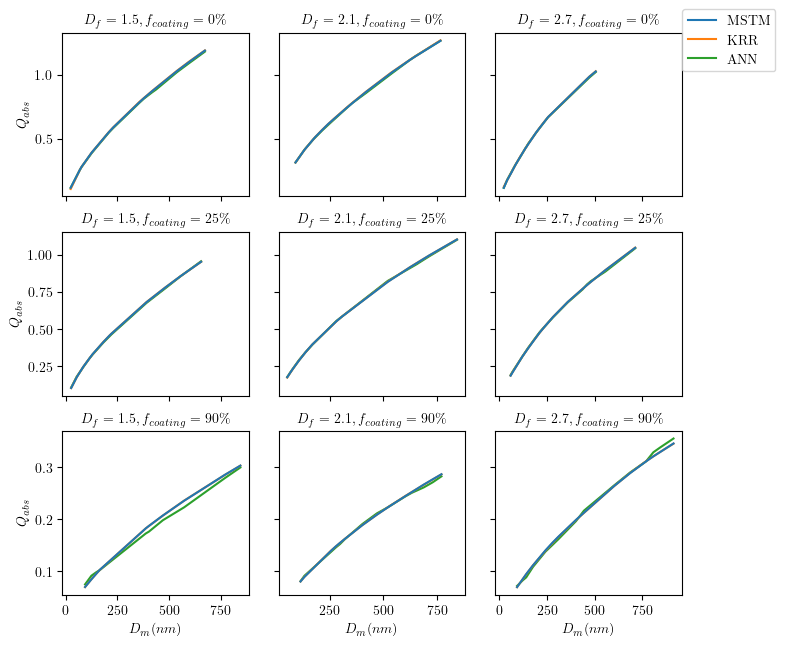

In [13]:
import os

os.makedirs('lineplots', exist_ok=True)
create_subplots(df_random[(df_random['wavelength']==660) & (df_random['equi_mobility_dia']<=1000)], 'equi_mobility_dia','q_abs', 'q_abs_pred_KRR', 'q_abs_pred_NN')

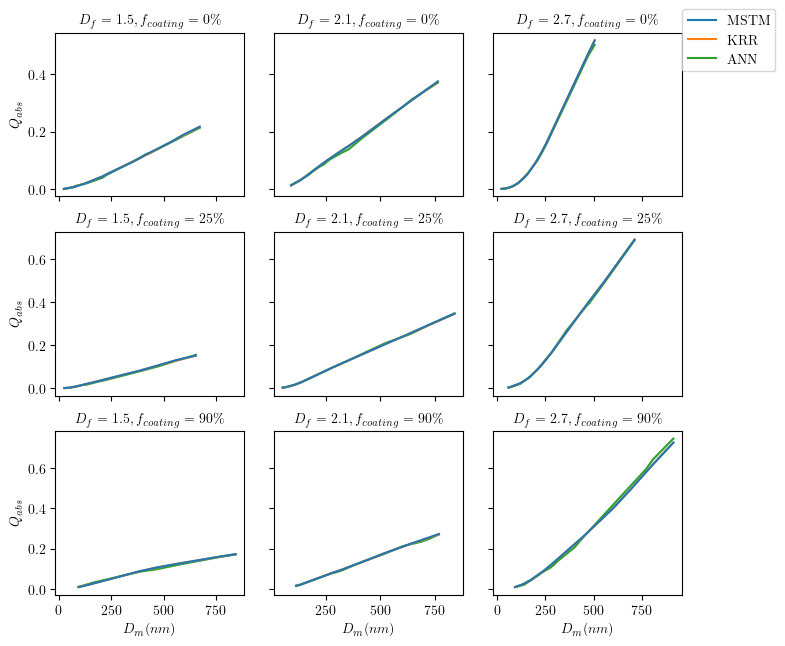

In [14]:
create_subplots(df_random[(df_random['wavelength']==660) & (df_random['equi_mobility_dia']<=1000)], 'equi_mobility_dia','q_sca', 'q_sca_pred_KRR', 'q_sca_pred_NN')

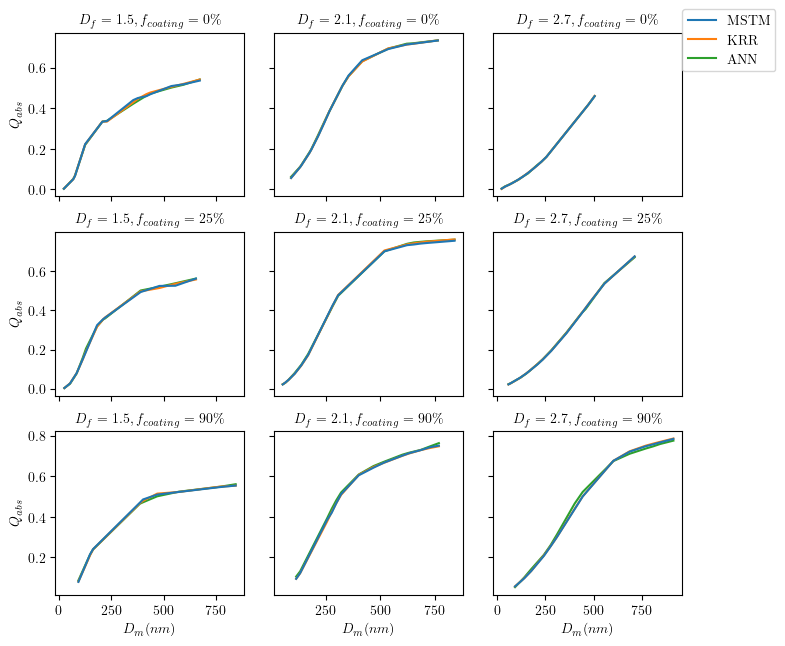

In [15]:
create_subplots(df_random[(df_random['wavelength']==660) & (df_random['equi_mobility_dia']<=1000)], 'equi_mobility_dia','g', 'g_pred_KRR', 'g_pred_NN')

In [16]:
def create_performance_plots(df_random):
    fig, axs = plt.subplots(3, 3, figsize= (1*text_width, 0.9*text_width), sharex= 'col', sharey='col')
    
    col_MSTM = 'q_abs'
    col_KRR = 'q_abs_pred_KRR'
    col_NN = 'q_abs_pred_NN'
    axs[0, 0].set_title('$D_f=1.5, f_{coating}=0\%$')
    x=df_random[(df_random['fractal_dimension']==1.5) & (df_random['fraction_of_coating']==0)][col_MSTM]
    y_KRR=df_random[(df_random['fractal_dimension']==1.5) & (df_random['fraction_of_coating']==0)][col_KRR]
    y_NN=df_random[(df_random['fractal_dimension']==1.5) & (df_random['fraction_of_coating']==0)][col_NN]
    p1 = max(max(y_KRR), max(y_NN), max(x))
    p2 = min(min(y_KRR), min(y_NN),min(x))
    axs[0, 0].scatter(x, y_KRR, c='crimson',marker='+')
    axs[0, 0].scatter(x, y_NN, c='green',marker='+')
    axs[0, 0].plot([p1, p2], [p1, p2], 'b-')
    axs[0, 0].set(ylabel='$\hat{Q}_{abs}$')

    axs[1, 0].set_title('$D_f=2.1, f_{coating}=50\%$')
    x=df_random[(df_random['fractal_dimension']==2.1) & (df_random['fraction_of_coating']==50)][col_MSTM]
    y_KRR=df_random[(df_random['fractal_dimension']==2.1) & (df_random['fraction_of_coating']==50)][col_KRR]
    y_NN=df_random[(df_random['fractal_dimension']==2.1) & (df_random['fraction_of_coating']==50)][col_NN]
    p1 = max(max(y_KRR), max(y_NN), max(x))
    p2 = min(min(y_KRR), min(y_NN),min(x))
    axs[1, 0].scatter(x, y_KRR, c='crimson',marker='+')
    axs[1, 0].scatter(x, y_NN, c='green',marker='+')
    axs[1, 0].plot([p1, p2], [p1, p2], 'b-')
    axs[1, 0].set(ylabel='$\hat{Q}_{abs}$')
    
    axs[2, 0].set_title('$D_f=2.7, f_{coating}=90\%$')
    x=df_random[(df_random['fractal_dimension']==2.7) & (df_random['fraction_of_coating']==90)][col_MSTM]
    y_KRR=df_random[(df_random['fractal_dimension']==2.7) & (df_random['fraction_of_coating']==90)][col_KRR]
    y_NN=df_random[(df_random['fractal_dimension']==2.7) & (df_random['fraction_of_coating']==90)][col_NN]
    p1 = max(max(y_KRR), max(y_NN), max(x))
    p2 = min(min(y_KRR), min(y_NN),min(x))
    axs[2, 0].scatter(x, y_KRR, c='crimson',marker='+')
    axs[2, 0].scatter(x, y_NN, c='green',marker='+')
    axs[2, 0].plot([p1, p2], [p1, p2], 'b-')
    axs[2, 0].set_xlabel('$Q_{abs}$')
    axs[2, 0].set(ylabel='$\hat{Q}_{abs}$')
    

    col_MSTM = 'q_sca'
    col_KRR = 'q_sca_pred_KRR'
    col_NN = 'q_sca_pred_NN'
    
    axs[0, 1].set_title('$D_f=1.5, f_{coating}=0\%$')
    x=df_random[(df_random['fractal_dimension']==1.5) & (df_random['fraction_of_coating']==0)][col_MSTM]
    y_KRR=df_random[(df_random['fractal_dimension']==1.5) & (df_random['fraction_of_coating']==0)][col_KRR]
    y_NN=df_random[(df_random['fractal_dimension']==1.5) & (df_random['fraction_of_coating']==0)][col_NN]
    p1 = max(max(y_KRR), max(y_NN), max(x))
    p2 = min(min(y_KRR), min(y_NN),min(x))
    axs[0,1].scatter(x, y_KRR, c='crimson',marker='+')
    axs[0,1].scatter(x, y_NN, c='green',marker='+')
    axs[0,1].plot([p1, p2], [p1, p2], 'b-')
    axs[0,1].set(ylabel='$\hat{Q}_{sca}$')
    
    axs[1, 1].set_title('$D_f=2.1, f_{coating}=50\%$')
    x=df_random[(df_random['fractal_dimension']==2.1) & (df_random['fraction_of_coating']==50)][col_MSTM]
    y_KRR=df_random[(df_random['fractal_dimension']==2.1) & (df_random['fraction_of_coating']==50)][col_KRR]
    y_NN=df_random[(df_random['fractal_dimension']==2.1) & (df_random['fraction_of_coating']==50)][col_NN]
    p1 = max(max(y_KRR), max(y_NN), max(x))
    p2 = min(min(y_KRR), min(y_NN),min(x))
    axs[1, 1].scatter(x, y_KRR, c='crimson',marker='+')
    axs[1, 1].scatter(x, y_NN, c='green',marker='+')
    axs[1, 1].plot([p1, p2], [p1, p2], 'b-')
    axs[1,1].set(ylabel='$\hat{Q}_{sca}$')

    axs[2, 1].set_title('$D_f=2.7, f_{coating}=90\%$')
    x=df_random[(df_random['fractal_dimension']==2.7) & (df_random['fraction_of_coating']==90)][col_MSTM]
    y_KRR=df_random[(df_random['fractal_dimension']==2.7) & (df_random['fraction_of_coating']==90)][col_KRR]
    y_NN=df_random[(df_random['fractal_dimension']==2.7) & (df_random['fraction_of_coating']==90)][col_NN]
    p1 = max(max(y_KRR), max(y_NN), max(x))
    p2 = min(min(y_KRR), min(y_NN),min(x))
    axs[2, 1].scatter(x, y_KRR, c='crimson',marker='+')
    axs[2, 1].scatter(x, y_NN, c='green',marker='+')
    axs[2, 1].plot([p1, p2], [p1, p2], 'b-')
    axs[2,1].set_xlabel('$Q_{sca}$')
    axs[2,1].set(ylabel='$\hat{Q}_{sca}$')
    
    
    col_MSTM = 'g'
    col_KRR = 'g_pred_KRR'
    col_NN = 'g_pred_NN'
    axs[0,2].set_title('$D_f=1.5, f_{coating}=0\%$')
    x=df_random[(df_random['fractal_dimension']==1.5) & (df_random['fraction_of_coating']==0)][col_MSTM]
    y_KRR=df_random[(df_random['fractal_dimension']==1.5) & (df_random['fraction_of_coating']==0)][col_KRR]
    y_NN=df_random[(df_random['fractal_dimension']==1.5) & (df_random['fraction_of_coating']==0)][col_NN]
    p1 = max(max(y_KRR), max(y_NN), max(x))
    p2 = min(min(y_KRR), min(y_NN),min(x))
    axs[0,2].scatter(x, y_KRR, c='crimson', label='KRR',marker='+')
    axs[0,2].scatter(x, y_NN, c='green',label='ANN',marker='+')
    axs[0,2].plot([p1, p2], [p1, p2], 'b-')
#     axs[0,2].set_xlabel('True $Q_{abs}$')
    axs[0,2].set(ylabel='$\hat{g}$')
#     axs[0,2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    
    axs[1,2].set_title('$D_f=2.1, f_{coating}=50\%$')
    x=df_random[(df_random['fractal_dimension']==2.1) & (df_random['fraction_of_coating']==50)][col_MSTM]
    y_KRR=df_random[(df_random['fractal_dimension']==2.1) & (df_random['fraction_of_coating']==50)][col_KRR]
    y_NN=df_random[(df_random['fractal_dimension']==2.1) & (df_random['fraction_of_coating']==50)][col_NN]
    p1 = max(max(y_KRR), max(y_NN), max(x))
    p2 = min(min(y_KRR), min(y_NN),min(x))
    axs[1,2].scatter(x, y_KRR, c='crimson',marker='+')
    axs[1,2].scatter(x, y_NN, c='green',marker='+')
    axs[1,2].plot([p1, p2], [p1, p2], 'b-')
    axs[1,2].set(ylabel='$\hat{g}$')
    
    
    
    
    axs[2, 2].set_title('$D_f=2.7, f_{coating}=90\%$')
    x=df_random[(df_random['fractal_dimension']==2.7) & (df_random['fraction_of_coating']==90)][col_MSTM]
    y_KRR=df_random[(df_random['fractal_dimension']==2.7) & (df_random['fraction_of_coating']==90)][col_KRR]
    y_NN=df_random[(df_random['fractal_dimension']==2.7) & (df_random['fraction_of_coating']==90)][col_NN]
    p1 = max(max(y_KRR), max(y_NN), max(x))
    p2 = min(min(y_KRR), min(y_NN),min(x))
    axs[2, 2].scatter(x, y_KRR, c='crimson',marker='+')
    axs[2, 2].scatter(x, y_NN, c='green',marker='+')
    axs[2, 2].plot([p1, p2], [p1, p2], 'b-')
    axs[2, 2].set_xlabel('$g$')
    axs[2, 2].set(ylabel='$\hat{g}$')

    
    
    fig.legend(loc='upper center', bbox_to_anchor=(1.05, 1))
    fig.tight_layout()
#     for ax in axs.flat:
#             ax.set(ylabel='Estimation')
    # Hide x labels and tick labels for top plots and y ticks for right plots.
#     for ax in axs.flat:
#         ax.label_outer()
        
    fig.savefig(f"performance_plots/performance_plot_random_660.pdf", format="pdf", bbox_inches="tight")

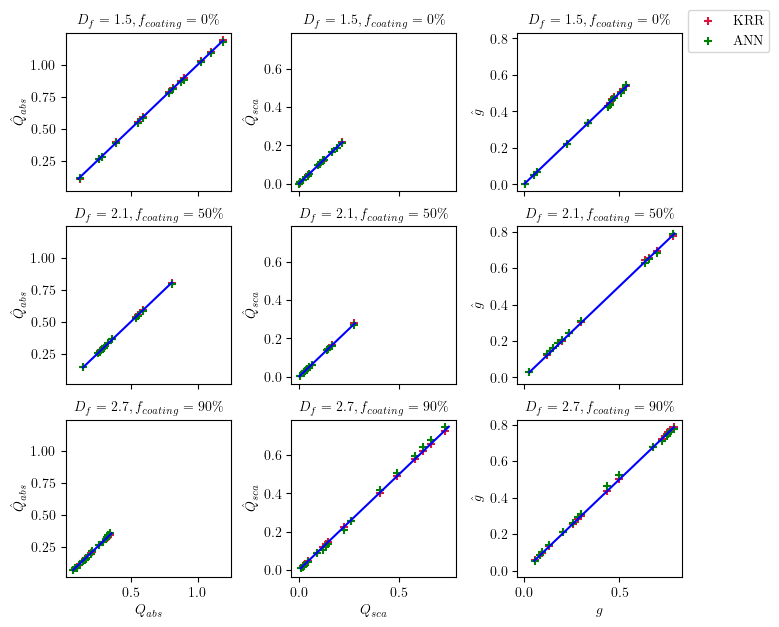

In [17]:
import os

os.makedirs('performance_plots', exist_ok=True)

create_performance_plots(df_random[df_random['wavelength']==660])

# Leave out fractal dimension(2.5,2.7,2.9) (KRR extrapolation)

In [19]:

train_set = df[(df['fractal_dimension'] < 2.5)]
test_set = df[(df['fractal_dimension'] >= 2.5)]
Y_train = train_set.iloc[:, 25:28]
X_train = train_set.iloc[:, :8]
Y_test = test_set.iloc[:, 25:28]
X_test = test_set.iloc[:, :8]

pt = PowerTransformer(method='box-cox')

X_test=X_test.reset_index(drop=True)
Y_test=Y_test.reset_index(drop=True)

X_train_transformed = pt.fit_transform(X_train+0.00000000001)
X_test_transformed = pt.transform(X_test+0.000000001)




print(pd.DataFrame({'cols':X_train.columns,'box_cox_lambdas':pt.lambdas_}))

regressor = KernelRidge(alpha=0.001, gamma=0.01, kernel='rbf')


model = regressor.fit(X_train_transformed,Y_train)


Y_pred = model.predict(X_test_transformed)


Y_pred_KRR = pd.DataFrame(data=Y_pred, columns=["q_abs_pred_KRR", "q_sca_pred_KRR","g_pred_KRR"])
#Y_test.reset_index(inplace=True)
#Y_test.drop('index',axis=1, inplace=True)
error = mean_absolute_error(Y_test, Y_pred_KRR, multioutput='raw_values')
max_error_q_abs, q_abs_max, min_error_q_abs, q_abs_min = min_max_error_efficiency(Y_test['q_abs'], Y_pred_KRR['q_abs_pred_KRR'])
max_error_q_sca, q_sca_max, min_error_q_sca, q_sca_min = min_max_error_efficiency(Y_test['q_sca'], Y_pred_KRR['q_sca_pred_KRR'])
max_error_g, g_max, min_error_g, g_min = min_max_error_efficiency(Y_test['g'], Y_pred_KRR['g_pred_KRR'])

mape  = mean_absolute_percentage_error(Y_test, Y_pred_KRR, multioutput='raw_values')

# error=calculate_mean_absolute_percentage_error_multi(parameter_alpha, parameter_kernel# parameter_gamma, X_train, Y_train, X_test, Y_test, scaling_y)
print('Mean absolute error on test set: ', mean_abs_error)
print(f'Max error is {max_error_q_abs} for  q_abs {q_abs_max} on test set')
print(f'Min error is {min_error_q_abs} for  q_abs {q_abs_min} on test set')

print(f'Max error is {max_error_q_sca} for  q_sca {q_sca_max} on test set')
print(f'Min error is {min_error_q_sca} for  q_sca {q_sca_min} on test set')

print(f'Max error is {max_error_g} for  g {g_max} on test set')
print(f'Min error is {min_error_g} for  g {g_min} on test set')


print('Mean absolute percentage error on test set: ', mape)
# Running and logging model plus Early stopping



                          cols  box_cox_lambdas
0                   wavelength        -1.882303
1            fractal_dimension         0.677943
2          fraction_of_coating         0.252202
3        primary_particle_size        -3.509534
4  number_of_primary_particles         0.108123
5        vol_equi_radius_outer         0.213367
6        vol_equi_radius_inner         0.324368
7            equi_mobility_dia         0.178682
Mean absolute error on test set:  [0.00391732 0.00306736 0.00387666]
Max error is 0.23065256791186628 for  q_abs 1.3881 on test set
Min error is 4.0286205249540075e-06 for  q_abs 0.53129 on test set
Max error is 0.5510518517105294 for  q_sca 1.3443 on test set
Min error is 4.078448410181623e-06 for  q_sca 0.0082809 on test set
Max error is 0.4296830483289276 for  g 0.0037985 on test set
Min error is 5.334418902536858e-06 for  g 0.012693 on test set
Mean absolute percentage error on test set:  [0.04960108 1.53344234 1.74203132]


In [21]:
train_set = df[(df['fractal_dimension'] < 2.5)]
test_set = df[(df['fractal_dimension'] >= 2.5)]
Y_train = train_set.iloc[:, 25:28]
X_train = train_set.iloc[:, :8]
Y_test = test_set.iloc[:, 25:28]
X_test = test_set.iloc[:, :8]
X_test=X_test.reset_index(drop=True)
Y_test=Y_test.reset_index(drop=True)
pt = PowerTransformer(method='box-cox')

X_test=X_test.reset_index(drop=True)
Y_test=Y_test.reset_index(drop=True)

X_train_transformed = pt.fit_transform(X_train+0.00000000001)
X_test_transformed = pt.transform(X_test+0.000000001)


print(pd.DataFrame({'cols':X_train.columns,'box_cox_lambdas':pt.lambdas_}))


model = load_model('../model_files/best_model_extra_fractal_dim.hdf5')
Y_pred_NN = model.predict(X_test_transformed)

Y_test = pd.DataFrame(data=Y_test, columns=["q_abs", "q_sca","g"])

Y_pred_NN = pd.DataFrame(data=Y_pred_NN, columns=["q_abs_pred_NN", "q_sca_pred_NN","g_pred_NN"])
#Y_test.reset_index(inplace=True)
#Y_test.drop('index',axis=1, inplace=True)
error = mean_absolute_error(Y_test, Y_pred_NN, multioutput='raw_values')
max_error_q_abs, q_abs_max, min_error_q_abs, q_abs_min = min_max_error_efficiency(Y_test['q_abs'], Y_pred_NN['q_abs_pred_NN'])
max_error_q_sca, q_sca_max, min_error_q_sca, q_sca_min = min_max_error_efficiency(Y_test['q_sca'], Y_pred_NN['q_sca_pred_NN'])
max_error_g, g_max, min_error_g, g_min = min_max_error_efficiency(Y_test['g'], Y_pred_NN['g_pred_NN'])

mape  = mean_absolute_percentage_error(Y_test, Y_pred_KRR, multioutput='raw_values')

# error=calculate_mean_absolute_percentage_error_multi(parameter_alpha, parameter_kernel# parameter_gamma, X_train, Y_train, X_test, Y_test, scaling_y)
print('Mean absolute error on test set: ', mean_abs_error)
print(f'Max error is {max_error_q_abs} for  q_abs {q_abs_max} on test set')
print(f'Min error is {min_error_q_abs} for  q_abs {q_abs_min} on test set')

print(f'Max error is {max_error_q_sca} for  q_sca {q_sca_max} on test set')
print(f'Min error is {min_error_q_sca} for  q_sca {q_sca_min} on test set')

print(f'Max error is {max_error_g} for  g {g_max} on test set')
print(f'Min error is {min_error_g} for  g {g_min} on test set')


print('Mean absolute percentage error on test set: ', mape)

                          cols  box_cox_lambdas
0                   wavelength        -1.882303
1            fractal_dimension         0.677943
2          fraction_of_coating         0.252202
3        primary_particle_size        -3.509534
4  number_of_primary_particles         0.108123
5        vol_equi_radius_outer         0.213367
6        vol_equi_radius_inner         0.324368
7            equi_mobility_dia         0.178682
Mean absolute error on test set:  [0.00391732 0.00306736 0.00387666]
Max error is 0.29266358737945564 for  q_abs 1.3663 on test set
Min error is 2.112083435035217e-06 for  q_abs 0.82257 on test set
Max error is 1.3610215421676637 for  q_sca 2.9546 on test set
Min error is 3.0848603248603834e-06 for  q_sca 0.045327 on test set
Max error is 0.331076279296875 for  g 0.47236 on test set
Min error is 5.640983581634007e-08 for  g 0.082275 on test set
Mean absolute percentage error on test set:  [0.04960108 1.53344234 1.74203132]


In [22]:
df_extrapol=pd.concat([X_test, Y_test, Y_pred_KRR, Y_pred_NN], axis =1)
df_extrapol= df_extrapol.sort_values(by=['equi_mobility_dia'])
df_extrapol=df_extrapol.reset_index(drop=True)
df_extrapol

,wavelength,fractal_dimension,fraction_of_coating,primary_particle_size,number_of_primary_particles,vol_equi_radius_outer,vol_equi_radius_inner,equi_mobility_dia,q_abs,q_sca,g,q_abs_pred_KRR,q_sca_pred_KRR,g_pred_KRR,q_abs_pred_NN,q_sca_pred_NN,g_pred_NN
0,660,2.5,1,15.1,0.5,11.984878,11.905508,16.845238,0.11691,0.000389,0.003798,0.103797,0.025345,0.240674,0.126416,0.002821,0.003361
1,467,2.9,1,15.1,0.5,11.984878,11.905508,16.845238,0.19030,0.001535,0.007075,0.130241,0.017822,0.222920,0.187729,0.009054,0.011637
2,660,2.7,1,15.1,0.5,11.984878,11.905508,16.845238,0.11691,0.000389,0.003798,0.089736,0.039061,0.335157,0.133158,0.002241,0.004120
3,530,2.5,1,15.1,0.5,11.984878,11.905508,16.845238,0.15654,0.000930,0.005690,0.126357,0.009370,0.160487,0.161712,0.002797,0.006076
4,530,2.7,1,15.1,0.5,11.984878,11.905508,16.845238,0.15654,0.000930,0.005690,0.112754,0.018301,0.233103,0.162809,0.003007,0.007077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6848,467,2.7,90,29.0,1000.0,290.000000,150.000000,1561.074003,1.36780,2.809100,0.925200,1.336719,2.442153,1.077580,1.265122,1.575081,0.946457
6849,530,2.7,90,29.0,1000.0,290.000000,150.000000,1561.074003,0.84669,1.919600,0.915940,0.824385,1.744891,1.073315,1.009471,1.324538,0.961545
6850,530,2.9,90,29.0,1000.0,290.000000,150.000000,1561.074003,0.88869,2.334300,0.882360,0.798027,2.095722,1.195202,1.027861,1.376616,0.977194
6851,660,2.9,90,29.0,1000.0,290.000000,150.000000,1561.074003,0.52617,1.826900,0.842540,0.425757,1.420386,1.137801,0.704095,1.010904,0.957179


In [23]:
def create_performance_plots(df_extrapol):
    fig, axs = plt.subplots(3, 3, figsize= (1*text_width, 0.9*text_width), sharex= 'col', sharey='col')
    
    col_MSTM = 'q_abs'
    col_KRR = 'q_abs_pred_KRR'
    col_NN = 'q_abs_pred_NN'
    axs[0, 0].set_title('$D_f=2.5, f_{coating}=0\%$')
    x=df_extrapol[(df_extrapol['fractal_dimension']==2.5) & (df_extrapol['fraction_of_coating']==0)][col_MSTM]
    y_KRR=df_extrapol[(df_extrapol['fractal_dimension']==2.5) & (df_extrapol['fraction_of_coating']==0)][col_KRR]
    y_NN=df_extrapol[(df_extrapol['fractal_dimension']==2.5) & (df_extrapol['fraction_of_coating']==0)][col_NN]
    p1 = max(max(y_KRR), max(y_NN), max(x))
    p2 = min(min(y_KRR), min(y_NN),min(x))
    axs[0, 0].scatter(x, y_KRR, c='crimson',marker='+')
    axs[0, 0].scatter(x, y_NN, c='green',marker='+')
    axs[0, 0].plot([p1, p2], [p1, p2], 'b-')
    axs[0, 0].set(ylabel='$\hat{Q}_{abs}$')

    axs[1, 0].set_title('$D_f=2.7, f_{coating}=50\%$')
    x=df_extrapol[(df_extrapol['fractal_dimension']==2.7) & (df_extrapol['fraction_of_coating']==50)][col_MSTM]
    y_KRR=df_extrapol[(df_extrapol['fractal_dimension']==2.7) & (df_extrapol['fraction_of_coating']==50)][col_KRR]
    y_NN=df_extrapol[(df_extrapol['fractal_dimension']==2.7) & (df_extrapol['fraction_of_coating']==50)][col_NN]
    p1 = max(max(y_KRR), max(y_NN), max(x))
    p2 = min(min(y_KRR), min(y_NN),min(x))
    axs[1, 0].scatter(x, y_KRR, c='crimson',marker='+')
    axs[1, 0].scatter(x, y_NN, c='green',marker='+')
    axs[1, 0].plot([p1, p2], [p1, p2], 'b-')
    axs[1, 0].set(ylabel='$\hat{Q}_{abs}$')
    
    axs[2, 0].set_title('$D_f=2.9, f_{coating}=90\%$')
    x=df_extrapol[(df_extrapol['fractal_dimension']==2.9) & (df_extrapol['fraction_of_coating']==90)][col_MSTM]
    y_KRR=df_extrapol[(df_extrapol['fractal_dimension']==2.9) & (df_extrapol['fraction_of_coating']==90)][col_KRR]
    y_NN=df_extrapol[(df_extrapol['fractal_dimension']==2.9) & (df_extrapol['fraction_of_coating']==90)][col_NN]
    p1 = max(max(y_KRR), max(y_NN), max(x))
    p2 = min(min(y_KRR), min(y_NN),min(x))
    axs[2, 0].scatter(x, y_KRR, c='crimson',marker='+')
    axs[2, 0].scatter(x, y_NN, c='green',marker='+')
    axs[2, 0].plot([p1, p2], [p1, p2], 'b-')
    axs[2, 0].set_xlabel('$Q_{abs}$')
    axs[2, 0].set(ylabel='$\hat{Q}_{abs}$')
    

    col_MSTM = 'q_sca'
    col_KRR = 'q_sca_pred_KRR'
    col_NN = 'q_sca_pred_NN'
    
    axs[0, 1].set_title('$D_f=2.5, f_{coating}=0\%$')
    x=df_extrapol[(df_extrapol['fractal_dimension']==2.5) & (df_extrapol['fraction_of_coating']==0)][col_MSTM]
    y_KRR=df_extrapol[(df_extrapol['fractal_dimension']==2.5) & (df_extrapol['fraction_of_coating']==0)][col_KRR]
    y_NN=df_extrapol[(df_extrapol['fractal_dimension']==2.5) & (df_extrapol['fraction_of_coating']==0)][col_NN]
    p1 = max(max(y_KRR), max(y_NN), max(x))
    p2 = min(min(y_KRR), min(y_NN),min(x))
    axs[0,1].scatter(x, y_KRR, c='crimson',marker='+')
    axs[0,1].scatter(x, y_NN, c='green',marker='+')
    axs[0,1].plot([p1, p2], [p1, p2], 'b-')
    axs[0,1].set(ylabel='$\hat{Q}_{sca}$')
    
    axs[1, 1].set_title('$D_f=2.7, f_{coating}=50\%$')
    x=df_extrapol[(df_extrapol['fractal_dimension']==2.7) & (df_extrapol['fraction_of_coating']==50)][col_MSTM]
    y_KRR=df_extrapol[(df_extrapol['fractal_dimension']==2.7) & (df_extrapol['fraction_of_coating']==50)][col_KRR]
    y_NN=df_extrapol[(df_extrapol['fractal_dimension']==2.7) & (df_extrapol['fraction_of_coating']==50)][col_NN]
    p1 = max(max(y_KRR), max(y_NN), max(x))
    p2 = min(min(y_KRR), min(y_NN),min(x))
    axs[1, 1].scatter(x, y_KRR, c='crimson',marker='+')
    axs[1, 1].scatter(x, y_NN, c='green',marker='+')
    axs[1, 1].plot([p1, p2], [p1, p2], 'b-')
    axs[1,1].set(ylabel='$\hat{Q}_{sca}$')

    axs[2, 1].set_title('$D_f=2.9, f_{coating}=90\%$')
    x=df_extrapol[(df_extrapol['fractal_dimension']==2.9) & (df_extrapol['fraction_of_coating']==90)][col_MSTM]
    y_KRR=df_extrapol[(df_extrapol['fractal_dimension']==2.9) & (df_extrapol['fraction_of_coating']==90)][col_KRR]
    y_NN=df_extrapol[(df_extrapol['fractal_dimension']==2.9) & (df_extrapol['fraction_of_coating']==90)][col_NN]
    p1 = max(max(y_KRR), max(y_NN), max(x))
    p2 = min(min(y_KRR), min(y_NN),min(x))
    axs[2, 1].scatter(x, y_KRR, c='crimson',marker='+')
    axs[2, 1].scatter(x, y_NN, c='green',marker='+')
    axs[2, 1].plot([p1, p2], [p1, p2], 'b-')
    axs[2,1].set_xlabel('$Q_{sca}$')
    axs[2,1].set(ylabel='$\hat{Q}_{sca}$')
    
    col_MSTM = 'g'
    col_KRR = 'g_pred_KRR'
    col_NN = 'g_pred_NN'
    axs[0,2].set_title('$D_f=2.5, f_{coating}=0\%$')
    x=df_extrapol[(df_extrapol['fractal_dimension']==2.5) & (df_extrapol['fraction_of_coating']==0)][col_MSTM]
    y_KRR=df_extrapol[(df_extrapol['fractal_dimension']==2.5) & (df_extrapol['fraction_of_coating']==0)][col_KRR]
    y_NN=df_extrapol[(df_extrapol['fractal_dimension']==2.5) & (df_extrapol['fraction_of_coating']==0)][col_NN]
    p1 = max(max(y_KRR), max(y_NN), max(x))
    p2 = min(min(y_KRR), min(y_NN),min(x))
    axs[0,2].scatter(x, y_KRR, c='crimson', label='KRR',marker='+')
    axs[0,2].scatter(x, y_NN, c='green', label='ANN',marker='+')
    axs[0,2].plot([p1, p2], [p1, p2], 'b-')
    axs[0,2].set(ylabel='$\hat{g}$')
    
    
    axs[1,2].set_title('$D_f=2.7, f_{coating}=50\%$')
    x=df_extrapol[(df_extrapol['fractal_dimension']==2.7) & (df_extrapol['fraction_of_coating']==50)][col_MSTM]
    y_KRR=df_extrapol[(df_extrapol['fractal_dimension']==2.7) & (df_extrapol['fraction_of_coating']==50)][col_KRR]
    y_NN=df_extrapol[(df_extrapol['fractal_dimension']==2.7) & (df_extrapol['fraction_of_coating']==50)][col_NN]
    p1 = max(max(y_KRR), max(y_NN), max(x))
    p2 = min(min(y_KRR), min(y_NN),min(x))
    axs[1,2].scatter(x, y_KRR, c='crimson',marker='+')
    axs[1,2].scatter(x, y_NN, c='green',marker='+')
    axs[1,2].plot([p1, p2], [p1, p2], 'b-')
    axs[1,2].set(ylabel='$\hat{g}$')
    
    
    
    
    axs[2, 2].set_title('$D_f=2.9, f_{coating}=90\%$')
    x=df_extrapol[(df_extrapol['fractal_dimension']==2.9) & (df_extrapol['fraction_of_coating']==90)][col_MSTM]
    y_KRR=df_extrapol[(df_extrapol['fractal_dimension']==2.9) & (df_extrapol['fraction_of_coating']==90)][col_KRR]
    y_NN=df_extrapol[(df_extrapol['fractal_dimension']==2.9) & (df_extrapol['fraction_of_coating']==90)][col_NN]
    p1 = max(max(y_KRR), max(y_NN), max(x))
    p2 = min(min(y_KRR), min(y_NN),min(x))
    axs[2, 2].scatter(x, y_KRR, c='crimson',marker='+')
    axs[2, 2].scatter(x, y_NN, c='green',marker='+')
    axs[2, 2].plot([p1, p2], [p1, p2], 'b-')
    axs[2, 2].set_xlabel('$g$')
    axs[2, 2].set(ylabel='$\hat{g}$')

    
    
    fig.legend(loc='upper center', bbox_to_anchor=(1.05, 1))
    fig.tight_layout()
        
    fig.savefig(f"performance_plots/performance_plot_extrapol_660.pdf", format="pdf", bbox_inches="tight")

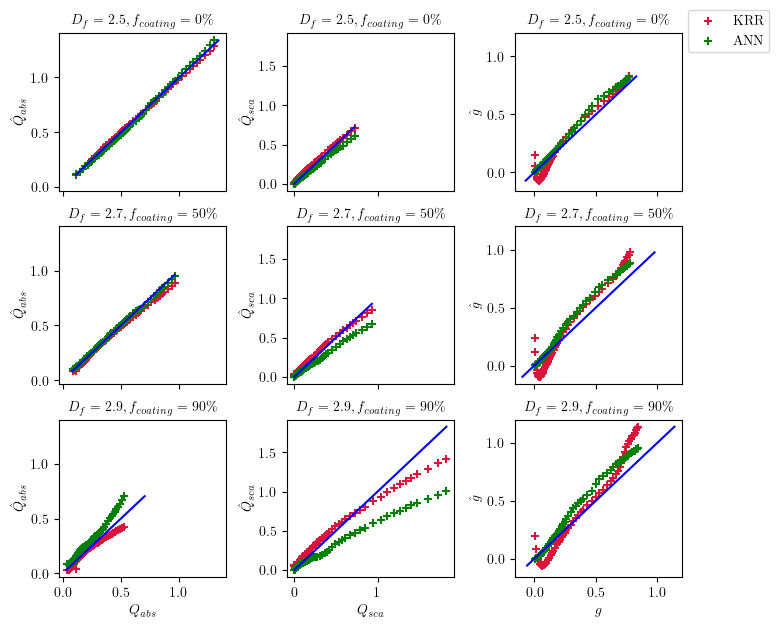

In [24]:
create_performance_plots(df_extrapol[df_extrapol['wavelength']==660])

In [25]:
def create_subplots(df_extrapol):
    fig, axs = plt.subplots(3, 3, figsize= (1*text_width, 0.9*text_width), sharex= 'col', sharey='row')
    
    x_axis = 'equi_mobility_dia'
    col_MSTM = 'q_abs'
    col_KRR = 'q_abs_pred_KRR'
    col_NN = 'q_abs_pred_NN'
    
    axs[0, 0].set_title('$D_f=2.5, f_{coating}=50\%$')
    x=df_extrapol[(df_extrapol['fractal_dimension']==2.5) & (df_extrapol['fraction_of_coating']==50)][x_axis]
    y=df_extrapol[(df_extrapol['fractal_dimension']==2.5) & (df_extrapol['fraction_of_coating']==50)][col_MSTM]
    y_KRR=df_extrapol[(df_extrapol['fractal_dimension']==2.5) & (df_extrapol['fraction_of_coating']==50)][col_KRR]
    y_NN=df_extrapol[(df_extrapol['fractal_dimension']==2.5) & (df_extrapol['fraction_of_coating']==50)][col_NN]
    axs[0, 0].plot(x, y, label= 'MSTM', zorder=3)
    axs[0, 0].plot(x, y_KRR, label='KRR', zorder=2)
    axs[0, 0].plot(x, y_NN, label='ANN', zorder=1)
    axs[0, 0].set(ylabel='$Q_{abs}$')
    
    axs[0, 1].set_title('$D_f=2.7, f_{coating}=50\%$')
    x=df_extrapol[(df_extrapol['fractal_dimension']==2.7) & (df_extrapol['fraction_of_coating']==50)][x_axis]
    y=df_extrapol[(df_extrapol['fractal_dimension']==2.7) & (df_extrapol['fraction_of_coating']==50)][col_MSTM]
    y_KRR=df_extrapol[(df_extrapol['fractal_dimension']==2.7) & (df_extrapol['fraction_of_coating']==50)][col_KRR]
    y_NN=df_extrapol[(df_extrapol['fractal_dimension']==2.7) & (df_extrapol['fraction_of_coating']==50)][col_NN]
    axs[0, 1].plot(x, y,zorder=3)
    axs[0, 1].plot(x, y_KRR, zorder=2)
    axs[0, 1].plot(x, y_NN, zorder=1)
    axs[0, 1].set(ylabel='$Q_{abs}$')
    
    axs[0, 2].set_title('$D_f=2.9, f_{coating}=50\%$')
    x=df_extrapol[(df_extrapol['fractal_dimension']==2.9) & (df_extrapol['fraction_of_coating']==50)][x_axis]
    y=df_extrapol[(df_extrapol['fractal_dimension']==2.9) & (df_extrapol['fraction_of_coating']==50)][col_MSTM]
    y_KRR=df_extrapol[(df_extrapol['fractal_dimension']==2.9) & (df_extrapol['fraction_of_coating']==50)][col_KRR]
    y_NN=df_extrapol[(df_extrapol['fractal_dimension']==2.9) & (df_extrapol['fraction_of_coating']==50)][col_NN]
    axs[0, 2].plot(x, y,zorder=3)
    axs[0, 2].plot(x, y_KRR, zorder=2)
    axs[0, 2].plot(x, y_NN, zorder=1)
    axs[0, 2].set(ylabel='$Q_{abs}$')
    
    x_axis = 'equi_mobility_dia'
    col_MSTM = 'q_sca'
    col_KRR = 'q_sca_pred_KRR'
    col_NN = 'q_sca_pred_NN'
    
    axs[1, 0].set_title('$D_f=2.5, f_{coating}=50\%$')
    x=df_extrapol[(df_extrapol['fractal_dimension']==2.5) & (df_extrapol['fraction_of_coating']==50)][x_axis]
    y=df_extrapol[(df_extrapol['fractal_dimension']==2.5) & (df_extrapol['fraction_of_coating']==50)][col_MSTM]
    y_KRR=df_extrapol[(df_extrapol['fractal_dimension']==2.5) & (df_extrapol['fraction_of_coating']==50)][col_KRR]
    y_NN=df_extrapol[(df_extrapol['fractal_dimension']==2.5) & (df_extrapol['fraction_of_coating']==50)][col_NN]
    axs[1, 0].plot(x, y,zorder=3)
    axs[1, 0].plot(x, y_KRR, zorder=2)
    axs[1, 0].plot(x, y_NN, zorder=1)
    axs[1, 0].set(ylabel='$Q_{sca}$')
    
    axs[1, 1].set_title('$D_f=2.7, f_{coating}=50\%$')
    x=df_extrapol[(df_extrapol['fractal_dimension']==2.7) & (df_extrapol['fraction_of_coating']==50)][x_axis]
    y=df_extrapol[(df_extrapol['fractal_dimension']==2.7) & (df_extrapol['fraction_of_coating']==50)][col_MSTM]
    y_KRR=df_extrapol[(df_extrapol['fractal_dimension']==2.7) & (df_extrapol['fraction_of_coating']==50)][col_KRR]
    y_NN=df_extrapol[(df_extrapol['fractal_dimension']==2.7) & (df_extrapol['fraction_of_coating']==50)][col_NN]
    axs[1, 1].plot(x, y,zorder=3)
    axs[1, 1].plot(x, y_KRR, zorder=2)
    axs[1, 1].plot(x, y_NN, zorder=1)
    axs[1, 1].set(ylabel='$Q_{sca}$')
    
    axs[1, 2].set_title('$D_f=2.9, f_{coating}=50\%$')
    x=df_extrapol[(df_extrapol['fractal_dimension']==2.9) & (df_extrapol['fraction_of_coating']==50)][x_axis]
    y=df_extrapol[(df_extrapol['fractal_dimension']==2.9) & (df_extrapol['fraction_of_coating']==50)][col_MSTM]
    y_KRR=df_extrapol[(df_extrapol['fractal_dimension']==2.9) & (df_extrapol['fraction_of_coating']==50)][col_KRR]
    y_NN=df_extrapol[(df_extrapol['fractal_dimension']==2.9) & (df_extrapol['fraction_of_coating']==50)][col_NN]
    axs[1, 2].plot(x, y,zorder=3)
    axs[1, 2].plot(x, y_KRR, zorder=2)
    axs[1, 2].plot(x, y_NN, zorder=1)
    axs[1, 2].set(ylabel='$Q_{sca}$')
    
    x_axis = 'equi_mobility_dia'
    col_MSTM = 'g'
    col_KRR = 'g_pred_KRR'
    col_NN = 'g_pred_NN'
    
    axs[2, 0].set_title('$D_f=2.5, f_{coating}=50\%$')
    x=df_extrapol[(df_extrapol['fractal_dimension']==2.5) & (df_extrapol['fraction_of_coating']==50)][x_axis]
    y=df_extrapol[(df_extrapol['fractal_dimension']==2.5) & (df_extrapol['fraction_of_coating']==50)][col_MSTM]
    y_KRR=df_extrapol[(df_extrapol['fractal_dimension']==2.5) & (df_extrapol['fraction_of_coating']==50)][col_KRR]
    y_NN=df_extrapol[(df_extrapol['fractal_dimension']==2.5) & (df_extrapol['fraction_of_coating']==50)][col_NN]
    axs[2, 0].plot(x, y,zorder=3)
    axs[2, 0].plot(x, y_KRR, zorder=2)
    axs[2, 0].plot(x, y_NN, zorder=1)
    axs[2, 0].set(ylabel='$g$')
    
    axs[2, 1].set_title('$D_f=2.7, f_{coating}=50\%$')
    x=df_extrapol[(df_extrapol['fractal_dimension']==2.7) & (df_extrapol['fraction_of_coating']==50)][x_axis]
    y=df_extrapol[(df_extrapol['fractal_dimension']==2.7) & (df_extrapol['fraction_of_coating']==50)][col_MSTM]
    y_KRR=df_extrapol[(df_extrapol['fractal_dimension']==2.7) & (df_extrapol['fraction_of_coating']==50)][col_KRR]
    y_NN=df_extrapol[(df_extrapol['fractal_dimension']==2.7) & (df_extrapol['fraction_of_coating']==50)][col_NN]
    axs[2, 1].plot(x, y,zorder=3)
    axs[2, 1].plot(x, y_KRR, zorder=2)
    axs[2, 1].plot(x, y_NN, zorder=1)
    axs[2, 1].set(ylabel='$g$')
    
    axs[2, 2].set_title('$D_f=2.9, f_{coating}=50\%$')
    x=df_extrapol[(df_extrapol['fractal_dimension']==2.9) & (df_extrapol['fraction_of_coating']==50)][x_axis]
    y=df_extrapol[(df_extrapol['fractal_dimension']==2.9) & (df_extrapol['fraction_of_coating']==50)][col_MSTM]
    y_KRR=df_extrapol[(df_extrapol['fractal_dimension']==2.9) & (df_extrapol['fraction_of_coating']==50)][col_KRR]
    y_NN=df_extrapol[(df_extrapol['fractal_dimension']==2.9) & (df_extrapol['fraction_of_coating']==50)][col_NN]
    axs[2, 2].plot(x, y,zorder=3)
    axs[2, 2].plot(x, y_KRR, zorder=2)
    axs[2, 2].plot(x, y_NN, zorder=1)
    axs[2, 2].set(ylabel='$g$')
    
    
    fig.legend(loc='upper center', bbox_to_anchor=(1.05, 1))
    fig.tight_layout()
    
    for ax in axs.flat:
        ax.set(xlabel='$D_m(nm)$')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
        
    fig.savefig(f"lineplots/lineplot_extrapol_660.pdf", format="pdf", bbox_inches="tight")

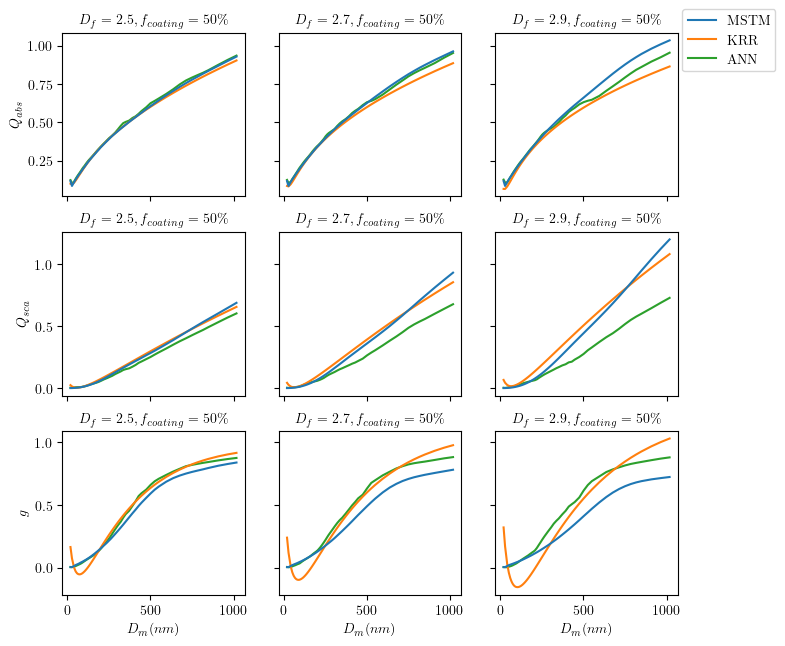

In [26]:
create_subplots(df_extrapol[df_extrapol['wavelength']==660])

# Leave out fractal dimension(2.1, 2.3, 2.5) (KRR)

In [27]:

train_set = df[(df['fractal_dimension'] < 2.1)|(df['fractal_dimension'] > 2.5)]
test_set = df[(df['fractal_dimension'] >= 2.1)&(df['fractal_dimension'] <= 2.5)]
Y_train = train_set.iloc[:, 25:28]
X_train = train_set.iloc[:, :8]
Y_test = test_set.iloc[:, 25:28]
X_test = test_set.iloc[:, :8]

pt = PowerTransformer(method='box-cox')

X_test=X_test.reset_index(drop=True)
Y_test=Y_test.reset_index(drop=True)

X_train_transformed = pt.fit_transform(X_train+0.00000000001)
X_test_transformed = pt.transform(X_test+0.000000001)




print(pd.DataFrame({'cols':X_train.columns,'box_cox_lambdas':pt.lambdas_}))

regressor = KernelRidge(alpha=0.001, gamma=0.01, kernel='rbf')


model = regressor.fit(X_train_transformed,Y_train)


Y_pred = model.predict(X_test_transformed)


Y_pred_KRR = pd.DataFrame(data=Y_pred, columns=["q_abs_pred_KRR", "q_sca_pred_KRR","g_pred_KRR"])
#Y_test.reset_index(inplace=True)
#Y_test.drop('index',axis=1, inplace=True)
error = mean_absolute_error(Y_test, Y_pred_KRR, multioutput='raw_values')
max_error_q_abs, q_abs_max, min_error_q_abs, q_abs_min = min_max_error_efficiency(Y_test['q_abs'], Y_pred_KRR['q_abs_pred_KRR'])
max_error_q_sca, q_sca_max, min_error_q_sca, q_sca_min = min_max_error_efficiency(Y_test['q_sca'], Y_pred_KRR['q_sca_pred_KRR'])
max_error_g, g_max, min_error_g, g_min = min_max_error_efficiency(Y_test['g'], Y_pred_KRR['g_pred_KRR'])

mape  = mean_absolute_percentage_error(Y_test, Y_pred_KRR, multioutput='raw_values')

# error=calculate_mean_absolute_percentage_error_multi(parameter_alpha, parameter_kernel# parameter_gamma, X_train, Y_train, X_test, Y_test, scaling_y)
print('Mean absolute error on test set: ', mean_abs_error)
print(f'Max error is {max_error_q_abs} for  q_abs {q_abs_max} on test set')
print(f'Min error is {min_error_q_abs} for  q_abs {q_abs_min} on test set')

print(f'Max error is {max_error_q_sca} for  q_sca {q_sca_max} on test set')
print(f'Min error is {min_error_q_sca} for  q_sca {q_sca_min} on test set')

print(f'Max error is {max_error_g} for  g {g_max} on test set')
print(f'Min error is {min_error_g} for  g {g_min} on test set')


print('Mean absolute percentage error on test set: ', mape)
# Running and logging model plus Early stopping



                          cols  box_cox_lambdas
0                   wavelength        -1.881724
1            fractal_dimension        -0.668197
2          fraction_of_coating         0.250824
3        primary_particle_size        -3.519745
4  number_of_primary_particles         0.107611
5        vol_equi_radius_outer         0.211656
6        vol_equi_radius_inner         0.322834
7            equi_mobility_dia         0.177527
Mean absolute error on test set:  [0.00391732 0.00306736 0.00387666]
Max error is 0.38780299814235897 for  q_abs 0.32901 on test set
Min error is 2.180292605014067e-06 for  q_abs 0.63187 on test set
Max error is 0.32425177946503164 for  q_sca 0.078355 on test set
Min error is 3.6150891360858806e-06 for  q_sca 0.044699 on test set
Max error is 0.4673180738685574 for  g 0.21173 on test set
Min error is 6.101370847784449e-06 for  g 0.051087 on test set
Mean absolute percentage error on test set:  [0.02716189 0.47918979 0.26120882]


In [28]:
train_set = df[(df['fractal_dimension'] < 2.1)|(df['fractal_dimension'] > 2.5)]
test_set = df[(df['fractal_dimension'] >= 2.1)&(df['fractal_dimension'] <= 2.5)]
Y_train = train_set.iloc[:, 25:28]
X_train = train_set.iloc[:, :8]
Y_test = test_set.iloc[:, 25:28]
X_test = test_set.iloc[:, :8]
X_test=X_test.reset_index(drop=True)
Y_test=Y_test.reset_index(drop=True)
pt = PowerTransformer(method='box-cox')

X_test=X_test.reset_index(drop=True)
Y_test=Y_test.reset_index(drop=True)

X_train_transformed = pt.fit_transform(X_train+0.00000000001)
X_test_transformed = pt.transform(X_test+0.000000001)


print(pd.DataFrame({'cols':X_train.columns,'box_cox_lambdas':pt.lambdas_}))


model = load_model('../model_files/best_model_intra_fractal_dim.hdf5')
Y_pred_NN = model.predict(X_test_transformed)

Y_test = pd.DataFrame(data=Y_test, columns=["q_abs", "q_sca","g"])

Y_pred_NN = pd.DataFrame(data=Y_pred_NN, columns=["q_abs_pred_NN", "q_sca_pred_NN","g_pred_NN"])
#Y_test.reset_index(inplace=True)
#Y_test.drop('index',axis=1, inplace=True)
error = mean_absolute_error(Y_test, Y_pred_NN, multioutput='raw_values')
max_error_q_abs, q_abs_max, min_error_q_abs, q_abs_min = min_max_error_efficiency(Y_test['q_abs'], Y_pred_NN['q_abs_pred_NN'])
max_error_q_sca, q_sca_max, min_error_q_sca, q_sca_min = min_max_error_efficiency(Y_test['q_sca'], Y_pred_NN['q_sca_pred_NN'])
max_error_g, g_max, min_error_g, g_min = min_max_error_efficiency(Y_test['g'], Y_pred_NN['g_pred_NN'])

mape  = mean_absolute_percentage_error(Y_test, Y_pred_KRR, multioutput='raw_values')

# error=calculate_mean_absolute_percentage_error_multi(parameter_alpha, parameter_kernel# parameter_gamma, X_train, Y_train, X_test, Y_test, scaling_y)
print('Mean absolute error on test set: ', mean_abs_error)
print(f'Max error is {max_error_q_abs} for  q_abs {q_abs_max} on test set')
print(f'Min error is {min_error_q_abs} for  q_abs {q_abs_min} on test set')

print(f'Max error is {max_error_q_sca} for  q_sca {q_sca_max} on test set')
print(f'Min error is {min_error_q_sca} for  q_sca {q_sca_min} on test set')

print(f'Max error is {max_error_g} for  g {g_max} on test set')
print(f'Min error is {min_error_g} for  g {g_min} on test set')


print('Mean absolute percentage error on test set: ', mape)

                          cols  box_cox_lambdas
0                   wavelength        -1.881724
1            fractal_dimension        -0.668197
2          fraction_of_coating         0.250824
3        primary_particle_size        -3.519745
4  number_of_primary_particles         0.107611
5        vol_equi_radius_outer         0.211656
6        vol_equi_radius_inner         0.322834
7            equi_mobility_dia         0.177527
Mean absolute error on test set:  [0.00391732 0.00306736 0.00387666]
Max error is 0.3403118946456909 for  q_abs 0.32901 on test set
Min error is 5.884170531378352e-08 for  q_abs 0.14045 on test set
Max error is 0.4454651885986327 for  q_sca 1.1019 on test set
Min error is 9.801825404168879e-06 for  q_sca 0.015762 on test set
Max error is 0.4486549530220032 for  g 0.21173 on test set
Min error is 4.632949829053157e-07 for  g 0.21955 on test set
Mean absolute percentage error on test set:  [0.02716189 0.47918979 0.26120882]


In [29]:
df_interpol=pd.concat([X_test, Y_test, Y_pred_KRR, Y_pred_NN], axis =1)
df_interpol= df_interpol.sort_values(by=['equi_mobility_dia'])
df_interpol=df_interpol.reset_index(drop=True)
df_interpol

,wavelength,fractal_dimension,fraction_of_coating,primary_particle_size,number_of_primary_particles,vol_equi_radius_outer,vol_equi_radius_inner,equi_mobility_dia,q_abs,q_sca,g,q_abs_pred_KRR,q_sca_pred_KRR,g_pred_KRR,q_abs_pred_NN,q_sca_pred_NN,g_pred_NN
0,467,2.3,1,15.1,0.5,11.984878,11.905508,16.845238,0.19030,0.001535,0.007075,0.171930,0.004653,-0.005867,0.161344,-0.002262,0.000698
1,660,2.1,1,15.1,0.5,11.984878,11.905508,16.845238,0.11691,0.000389,0.003798,0.124716,0.000322,-0.031959,0.116271,-0.001467,-0.000228
2,467,2.5,1,15.1,0.5,11.984878,11.905508,16.845238,0.19030,0.001535,0.007075,0.170070,0.007525,0.010961,0.161205,-0.002434,0.001327
3,660,2.3,1,15.1,0.5,11.984878,11.905508,16.845238,0.11691,0.000389,0.003798,0.125257,0.001880,-0.007999,0.116754,-0.001465,-0.000327
4,530,2.5,1,15.1,0.5,11.984878,11.905508,16.845238,0.15654,0.000930,0.005690,0.144194,-0.001137,0.009383,0.141098,-0.003182,0.002014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6811,467,2.3,90,29.0,1000.0,290.000000,150.000000,1561.074003,1.44490,1.890900,0.874810,1.393511,1.966693,0.795442,1.240957,1.978336,0.958716
6812,660,2.5,90,29.0,1000.0,290.000000,150.000000,1561.074003,0.45801,1.003600,0.900450,0.475092,1.142791,0.847192,0.560106,1.372272,0.939184
6813,660,2.3,90,29.0,1000.0,290.000000,150.000000,1561.074003,0.45054,0.710570,0.872220,0.461768,0.900236,0.820763,0.501853,1.109569,0.902402
6814,530,2.3,90,29.0,1000.0,290.000000,150.000000,1561.074003,0.84277,1.101900,0.875120,0.867195,1.367375,0.818147,0.859992,1.547365,0.940975


In [30]:
def create_subplots(df_interpol):
    fig, axs = plt.subplots(3, 3, figsize= (1*text_width, 0.9*text_width), sharex= 'col', sharey='row')
    
    x_axis = 'equi_mobility_dia'
    col_MSTM = 'q_abs'
    col_KRR = 'q_abs_pred_KRR'
    col_NN = 'q_abs_pred_NN'
    
    axs[0, 0].set_title('$D_f=2.1, f_{coating}=50\%$')
    x=df_interpol[(df_interpol['fractal_dimension']==2.1) & (df_interpol['fraction_of_coating']==50)][x_axis]
    y=df_interpol[(df_interpol['fractal_dimension']==2.1) & (df_interpol['fraction_of_coating']==50)][col_MSTM]
    y_KRR=df_interpol[(df_interpol['fractal_dimension']==2.1) & (df_interpol['fraction_of_coating']==50)][col_KRR]
    y_NN=df_interpol[(df_interpol['fractal_dimension']==2.1) & (df_interpol['fraction_of_coating']==50)][col_NN]
    axs[0, 0].plot(x, y, label= 'MSTM', zorder=3)
    axs[0, 0].plot(x, y_KRR, label='KRR', zorder=2)
    axs[0, 0].plot(x, y_NN, label='ANN', zorder=1)
    axs[0, 0].set(ylabel='$Q_{abs}$')
    
    axs[0, 1].set_title('$D_f=2.3, f_{coating}=50\%$')
    x=df_interpol[(df_interpol['fractal_dimension']==2.3) & (df_interpol['fraction_of_coating']==50)][x_axis]
    y=df_interpol[(df_interpol['fractal_dimension']==2.3) & (df_interpol['fraction_of_coating']==50)][col_MSTM]
    y_KRR=df_interpol[(df_interpol['fractal_dimension']==2.3) & (df_interpol['fraction_of_coating']==50)][col_KRR]
    y_NN=df_interpol[(df_interpol['fractal_dimension']==2.3) & (df_interpol['fraction_of_coating']==50)][col_NN]
    axs[0, 1].plot(x, y,zorder=3)
    axs[0, 1].plot(x, y_KRR, zorder=2)
    axs[0, 1].plot(x, y_NN, zorder=1)
#     axs[0, 1].set(ylabel='$Q_{abs}$')
    
    axs[0, 2].set_title('$D_f=2.5, f_{coating}=50\%$')
    x=df_interpol[(df_interpol['fractal_dimension']==2.5) & (df_interpol['fraction_of_coating']==50)][x_axis]
    y=df_interpol[(df_interpol['fractal_dimension']==2.5) & (df_interpol['fraction_of_coating']==50)][col_MSTM]
    y_KRR=df_interpol[(df_interpol['fractal_dimension']==2.5) & (df_interpol['fraction_of_coating']==50)][col_KRR]
    y_NN=df_interpol[(df_interpol['fractal_dimension']==2.5) & (df_interpol['fraction_of_coating']==50)][col_NN]
    axs[0, 2].plot(x, y,zorder=3)
    axs[0, 2].plot(x, y_KRR, zorder=2)
    axs[0, 2].plot(x, y_NN, zorder=1)
#     axs[0, 2].set(ylabel='$Q_{abs}$')
    
    x_axis = 'equi_mobility_dia'
    col_MSTM = 'q_sca'
    col_KRR = 'q_sca_pred_KRR'
    col_NN = 'q_sca_pred_NN'
    
    axs[1, 0].set_title('$D_f=2.1, f_{coating}=50\%$')
    x=df_interpol[(df_interpol['fractal_dimension']==2.1) & (df_interpol['fraction_of_coating']==50)][x_axis]
    y=df_interpol[(df_interpol['fractal_dimension']==2.1) & (df_interpol['fraction_of_coating']==50)][col_MSTM]
    y_KRR=df_interpol[(df_interpol['fractal_dimension']==2.1) & (df_interpol['fraction_of_coating']==50)][col_KRR]
    y_NN=df_interpol[(df_interpol['fractal_dimension']==2.1) & (df_interpol['fraction_of_coating']==50)][col_NN]
    axs[1, 0].plot(x, y,zorder=3)
    axs[1, 0].plot(x, y_KRR, zorder=2)
    axs[1, 0].plot(x, y_NN, zorder=1)
    axs[1, 0].set(ylabel='$Q_{sca}$')
    
    axs[1, 1].set_title('$D_f=2.3, f_{coating}=50\%$')
    x=df_interpol[(df_interpol['fractal_dimension']==2.3) & (df_interpol['fraction_of_coating']==50)][x_axis]
    y=df_interpol[(df_interpol['fractal_dimension']==2.3) & (df_interpol['fraction_of_coating']==50)][col_MSTM]
    y_KRR=df_interpol[(df_interpol['fractal_dimension']==2.3) & (df_interpol['fraction_of_coating']==50)][col_KRR]
    y_NN=df_interpol[(df_interpol['fractal_dimension']==2.3) & (df_interpol['fraction_of_coating']==50)][col_NN]
    axs[1, 1].plot(x, y,zorder=3)
    axs[1, 1].plot(x, y_KRR, zorder=2)
    axs[1, 1].plot(x, y_NN, zorder=1)
#     axs[1, 1].set(ylabel='$Q_{sca}$')
    
    axs[1, 2].set_title('$D_f=2.5, f_{coating}=50\%$')
    x=df_interpol[(df_interpol['fractal_dimension']==2.5) & (df_interpol['fraction_of_coating']==50)][x_axis]
    y=df_interpol[(df_interpol['fractal_dimension']==2.5) & (df_interpol['fraction_of_coating']==50)][col_MSTM]
    y_KRR=df_interpol[(df_interpol['fractal_dimension']==2.5) & (df_interpol['fraction_of_coating']==50)][col_KRR]
    y_NN=df_interpol[(df_interpol['fractal_dimension']==2.5) & (df_interpol['fraction_of_coating']==50)][col_NN]
    axs[1, 2].plot(x, y,zorder=3)
    axs[1, 2].plot(x, y_KRR, zorder=2)
    axs[1, 2].plot(x, y_NN, zorder=1)
#     axs[1, 2].set(ylabel='$Q_{sca}$')
    
    x_axis = 'equi_mobility_dia'
    col_MSTM = 'g'
    col_KRR = 'g_pred_KRR'
    col_NN = 'g_pred_NN'
    
    axs[2, 0].set_title('$D_f=2.1, f_{coating}=50\%$')
    x=df_interpol[(df_interpol['fractal_dimension']==2.1) & (df_interpol['fraction_of_coating']==50)][x_axis]
    y=df_interpol[(df_interpol['fractal_dimension']==2.1) & (df_interpol['fraction_of_coating']==50)][col_MSTM]
    y_KRR=df_interpol[(df_interpol['fractal_dimension']==2.1) & (df_interpol['fraction_of_coating']==50)][col_KRR]
    y_NN=df_interpol[(df_interpol['fractal_dimension']==2.1) & (df_interpol['fraction_of_coating']==50)][col_NN]
    axs[2, 0].plot(x, y,zorder=3)
    axs[2, 0].plot(x, y_KRR, zorder=2)
    axs[2, 0].plot(x, y_NN, zorder=1)
    axs[2, 0].set(ylabel='$g$')
    
    axs[2, 1].set_title('$D_f=2.3, f_{coating}=50\%$')
    x=df_interpol[(df_interpol['fractal_dimension']==2.3) & (df_interpol['fraction_of_coating']==50)][x_axis]
    y=df_interpol[(df_interpol['fractal_dimension']==2.3) & (df_interpol['fraction_of_coating']==50)][col_MSTM]
    y_KRR=df_interpol[(df_interpol['fractal_dimension']==2.3) & (df_interpol['fraction_of_coating']==50)][col_KRR]
    y_NN=df_interpol[(df_interpol['fractal_dimension']==2.3) & (df_interpol['fraction_of_coating']==50)][col_NN]
    axs[2, 1].plot(x, y,zorder=3)
    axs[2, 1].plot(x, y_KRR, zorder=2)
    axs[2, 1].plot(x, y_NN, zorder=1)
#     axs[2, 1].set(ylabel='$g$')
    
    axs[2, 2].set_title('$D_f=2.5, f_{coating}=50\%$')
    x=df_interpol[(df_interpol['fractal_dimension']==2.5) & (df_interpol['fraction_of_coating']==50)][x_axis]
    y=df_interpol[(df_interpol['fractal_dimension']==2.5) & (df_interpol['fraction_of_coating']==50)][col_MSTM]
    y_KRR=df_interpol[(df_interpol['fractal_dimension']==2.5) & (df_interpol['fraction_of_coating']==50)][col_KRR]
    y_NN=df_interpol[(df_interpol['fractal_dimension']==2.5) & (df_interpol['fraction_of_coating']==50)][col_NN]
    axs[2, 2].plot(x, y,zorder=3)
    axs[2, 2].plot(x, y_KRR, zorder=2)
    axs[2, 2].plot(x, y_NN, zorder=1)
#     axs[2, 2].set(ylabel='$g$')
    
    
    fig.legend(loc='upper center', bbox_to_anchor=(1.05, 1))
    fig.tight_layout()
    
    for ax in axs.flat:
        ax.set(xlabel='$D_m(nm)$')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
        
    fig.savefig(f"lineplots/lineplot_interpol_660.pdf", format="pdf", bbox_inches="tight")



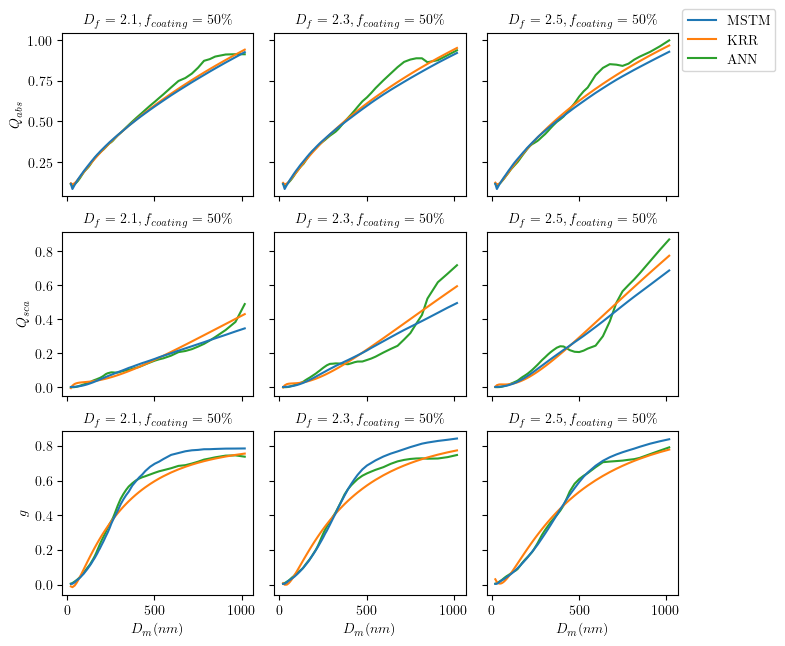

In [31]:
create_subplots(df_interpol[df_interpol['wavelength']==660])

In [32]:
def create_performance_plots(df_interpol):
    fig, axs = plt.subplots(3, 3, figsize= (1*text_width, 0.9*text_width), sharex= 'col', sharey='col')
    
    col_MSTM = 'q_abs'
    col_KRR = 'q_abs_pred_KRR'
    col_NN = 'q_abs_pred_NN'
    axs[0, 0].set_title('$D_f=2.1, f_{coating}=0\%$')
    x=df_interpol[(df_interpol['fractal_dimension']==2.1) & (df_interpol['fraction_of_coating']==0)][col_MSTM]
    y_KRR=df_interpol[(df_interpol['fractal_dimension']==2.1) & (df_interpol['fraction_of_coating']==0)][col_KRR]
    y_NN=df_interpol[(df_interpol['fractal_dimension']==2.1) & (df_interpol['fraction_of_coating']==0)][col_NN]
    p1 = max(max(y_KRR), max(y_NN), max(x))
    p2 = min(min(y_KRR), min(y_NN),min(x))
    axs[0, 0].scatter(x, y_KRR, c='crimson',marker='+')
    axs[0, 0].scatter(x, y_NN, c='green',marker='+')
    axs[0, 0].plot([p1, p2], [p1, p2], 'b-')
    axs[0, 0].set(ylabel='$\hat{Q}_{abs}$')

    axs[1, 0].set_title('$D_f=2.3, f_{coating}=50\%$')
    x=df_interpol[(df_interpol['fractal_dimension']==2.3) & (df_interpol['fraction_of_coating']==50)][col_MSTM]
    y_KRR=df_interpol[(df_interpol['fractal_dimension']==2.3) & (df_interpol['fraction_of_coating']==50)][col_KRR]
    y_NN=df_interpol[(df_interpol['fractal_dimension']==2.3) & (df_interpol['fraction_of_coating']==50)][col_NN]
    p1 = max(max(y_KRR), max(y_NN), max(x))
    p2 = min(min(y_KRR), min(y_NN),min(x))
    axs[1, 0].scatter(x, y_KRR, c='crimson',marker='+')
    axs[1, 0].scatter(x, y_NN, c='green',marker='+')
    axs[1, 0].plot([p1, p2], [p1, p2], 'b-')
    axs[1, 0].set(ylabel='$\hat{Q}_{abs}$')
    
    axs[2, 0].set_title('$D_f=2.5, f_{coating}=90\%$')
    x=df_interpol[(df_interpol['fractal_dimension']==2.5) & (df_interpol['fraction_of_coating']==90)][col_MSTM]
    y_KRR=df_interpol[(df_interpol['fractal_dimension']==2.5) & (df_interpol['fraction_of_coating']==90)][col_KRR]
    y_NN=df_interpol[(df_interpol['fractal_dimension']==2.5) & (df_interpol['fraction_of_coating']==90)][col_NN]
    p1 = max(max(y_KRR), max(y_NN), max(x))
    p2 = min(min(y_KRR), min(y_NN),min(x))
    axs[2, 0].scatter(x, y_KRR, c='crimson',marker='+')
    axs[2, 0].scatter(x, y_NN, c='green',marker='+')
    axs[2, 0].plot([p1, p2], [p1, p2], 'b-')
    axs[2, 0].set_xlabel('$Q_{abs}$')
    axs[2, 0].set(ylabel='$\hat{Q}_{abs}$')
    

    col_MSTM = 'q_sca'
    col_KRR = 'q_sca_pred_KRR'
    col_NN = 'q_sca_pred_NN'
    
    axs[0, 1].set_title('$D_f=2.1, f_{coating}=0\%$')
    x=df_interpol[(df_interpol['fractal_dimension']==2.1) & (df_interpol['fraction_of_coating']==0)][col_MSTM]
    y_KRR=df_interpol[(df_interpol['fractal_dimension']==2.1) & (df_interpol['fraction_of_coating']==0)][col_KRR]
    y_NN=df_interpol[(df_interpol['fractal_dimension']==2.1) & (df_interpol['fraction_of_coating']==0)][col_NN]
    p1 = max(max(y_KRR), max(y_NN), max(x))
    p2 = min(min(y_KRR), min(y_NN),min(x))
    axs[0,1].scatter(x, y_KRR, c='crimson',marker='+')
    axs[0,1].scatter(x, y_NN, c='green',marker='+')
    axs[0,1].plot([p1, p2], [p1, p2], 'b-')
    axs[0,1].set(ylabel='$\hat{Q}_{sca}$')
    
    axs[1, 1].set_title('$D_f=2.3, f_{coating}=50\%$')
    x=df_interpol[(df_interpol['fractal_dimension']==2.3) & (df_interpol['fraction_of_coating']==50)][col_MSTM]
    y_KRR=df_interpol[(df_interpol['fractal_dimension']==2.3) & (df_interpol['fraction_of_coating']==50)][col_KRR]
    y_NN=df_interpol[(df_interpol['fractal_dimension']==2.3) & (df_interpol['fraction_of_coating']==50)][col_NN]
    p1 = max(max(y_KRR), max(y_NN), max(x))
    p2 = min(min(y_KRR), min(y_NN),min(x))
    axs[1, 1].scatter(x, y_KRR, c='crimson',marker='+')
    axs[1, 1].scatter(x, y_NN, c='green',marker='+')
    axs[1, 1].plot([p1, p2], [p1, p2], 'b-')
    axs[1,1].set(ylabel='$\hat{Q}_{sca}$')

    axs[2, 1].set_title('$D_f=2.5, f_{coating}=90\%$')
    x=df_interpol[(df_interpol['fractal_dimension']==2.5) & (df_interpol['fraction_of_coating']==90)][col_MSTM]
    y_KRR=df_interpol[(df_interpol['fractal_dimension']==2.5) & (df_interpol['fraction_of_coating']==90)][col_KRR]
    y_NN=df_interpol[(df_interpol['fractal_dimension']==2.5) & (df_interpol['fraction_of_coating']==90)][col_NN]
    p1 = max(max(y_KRR), max(y_NN), max(x))
    p2 = min(min(y_KRR), min(y_NN),min(x))
    axs[2, 1].scatter(x, y_KRR, c='crimson',marker='+')
    axs[2, 1].scatter(x, y_NN, c='green',marker='+')
    axs[2, 1].plot([p1, p2], [p1, p2], 'b-')
    axs[2,1].set_xlabel('$Q_{sca}$')
    axs[2,1].set(ylabel='$\hat{Q}_{sca}$')
    
    
    col_MSTM = 'g'
    col_KRR = 'g_pred_KRR'
    col_NN = 'g_pred_NN'
    axs[0,2].set_title('$D_f=2.1, f_{coating}=0\%$')
    x=df_interpol[(df_interpol['fractal_dimension']==2.1) & (df_interpol['fraction_of_coating']==0)][col_MSTM]
    y_KRR=df_interpol[(df_interpol['fractal_dimension']==2.1) & (df_interpol['fraction_of_coating']==0)][col_KRR]
    y_NN=df_interpol[(df_interpol['fractal_dimension']==2.1) & (df_interpol['fraction_of_coating']==0)][col_NN]
    p1 = max(max(y_KRR), max(y_NN), max(x))
    p2 = min(min(y_KRR), min(y_NN),min(x))
    axs[0,2].scatter(x, y_KRR, c='crimson',label='KRR',marker='+')
    axs[0,2].scatter(x, y_NN, c='green', label='ANN',marker='+')
    axs[0,2].plot([p1, p2], [p1, p2], 'b-')
#     axs[0,2].set_xlabel('True $Q_{abs}$')
    axs[0,2].set(ylabel='$\hat{g}$')
    
    
    axs[1,2].set_title('$D_f=2.3, f_{coating}=50\%$')
    x=df_interpol[(df_interpol['fractal_dimension']==2.3) & (df_interpol['fraction_of_coating']==50)][col_MSTM]
    y_KRR=df_interpol[(df_interpol['fractal_dimension']==2.3) & (df_interpol['fraction_of_coating']==50)][col_KRR]
    y_NN=df_interpol[(df_interpol['fractal_dimension']==2.3) & (df_interpol['fraction_of_coating']==50)][col_NN]
    p1 = max(max(y_KRR), max(y_NN), max(x))
    p2 = min(min(y_KRR), min(y_NN),min(x))
    axs[1,2].scatter(x, y_KRR, c='crimson',marker='+')
    axs[1,2].scatter(x, y_NN, c='green',marker='+')
    axs[1,2].plot([p1, p2], [p1, p2], 'b-')
    axs[1,2].set(ylabel='$\hat{g}$')
    
    
    
    
    axs[2, 2].set_title('$D_f=2.5, f_{coating}=90\%$')
    x=df_interpol[(df_interpol['fractal_dimension']==2.5) & (df_interpol['fraction_of_coating']==90)][col_MSTM]
    y_KRR=df_interpol[(df_interpol['fractal_dimension']==2.5) & (df_interpol['fraction_of_coating']==90)][col_KRR]
    y_NN=df_interpol[(df_interpol['fractal_dimension']==2.5) & (df_interpol['fraction_of_coating']==90)][col_NN]
    p1 = max(max(y_KRR), max(y_NN), max(x))
    p2 = min(min(y_KRR), min(y_NN),min(x))
    axs[2, 2].scatter(x, y_KRR, c='crimson',marker='+')
    axs[2, 2].scatter(x, y_NN, c='green',marker='+')
    axs[2, 2].plot([p1, p2], [p1, p2], 'b-')
    axs[2, 2].set_xlabel('$g$')
    axs[2, 2].set(ylabel='$\hat{g}$')

    
    
    fig.legend(loc='upper center', bbox_to_anchor=(1.05, 1))
    fig.tight_layout()
        
    fig.savefig(f"performance_plots/performance_plot_interpol_660.pdf", format="pdf", bbox_inches="tight")

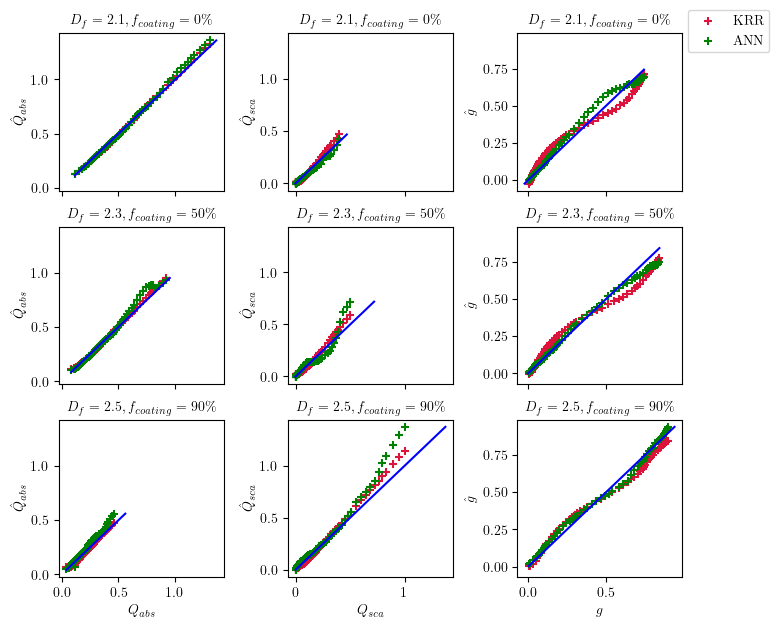

In [33]:
create_performance_plots(df_interpol[df_interpol['wavelength']==660])

In [34]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

In [35]:
def create_boxplots(df_random, df_extrapol, df_interpol, feature_x):
    fig, axs = plt.subplots(3, 3, figsize= (0.9*text_width, 0.9*text_width), sharex=True, sharey='row')
    
    data_KRR=[]
    data_NN=[]
    ticks=[]
    for i in np.sort(df_random[feature_x].unique()):
        mstm_values=df_random[(df_random[feature_x]==i)]['q_abs']
        KRR_values=df_random[(df_random[feature_x]==i)]['q_abs_pred_KRR']
        NN_values=df_random[(df_random[feature_x]==i)]['q_abs_pred_NN']
        l1=KRR_values.to_numpy()-mstm_values
        l2=NN_values.to_numpy()-mstm_values
        data_KRR.append(l1)
        data_NN.append(l2)
        ticks.append(i)
    
    # Creating plot
    bpl=axs[0,0].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[0,0].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_NN)))*2.0+0.4, sym="")
    axs[0,0].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[0,0].plot([], c='#D7191C')
    axs[0,0].plot([], c='#2C7BB6')
    axs[0,0].set_xticks(range(0, len(ticks) * 2, 2), ticks)
    axs[0,0].set(ylabel='$\hat{Q_{abs}}-Q_{abs}$')
    axs[0,0].title.set_text('Random split')
    
    
    ######
    
    data_KRR=[]
    data_NN=[]
    ticks=[]
    for i in np.sort(df_interpol[feature_x].unique()):
        mstm_values=df_interpol[(df_interpol[feature_x]==i)]['q_abs']
        KRR_values=df_interpol[(df_interpol[feature_x]==i)]['q_abs_pred_KRR']
        NN_values=df_interpol[(df_interpol[feature_x]==i)]['q_abs_pred_NN']
        l1=KRR_values.to_numpy()-mstm_values
        l2=NN_values.to_numpy()-mstm_values
        data_KRR.append(l1)
        data_NN.append(l2)
        ticks.append(i)
    
    # Creating plot
    bpl=axs[0,1].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[0,1].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_NN)))*2.0+0.4, sym="")
    axs[0,1].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    l1=axs[0,1].plot([], c='#D7191C', label='KRR')
    l2=axs[0,1].plot([], c='#2C7BB6', label='NN')
    axs[0,1].set_xticks(range(0, len(ticks) * 2, 2), ticks)
    axs[0,1].title.set_text('Interpolation split')
#     axs[0,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ########
    data_KRR=[]
    data_NN=[]
    ticks=[]
    for i in np.sort(df_extrapol[feature_x].unique()):
        mstm_values=df_extrapol[(df_extrapol[feature_x]==i)]['q_abs']
        KRR_values=df_extrapol[(df_extrapol[feature_x]==i)]['q_abs_pred_KRR']
        NN_values=df_extrapol[(df_extrapol[feature_x]==i)]['q_abs_pred_NN']
        l1=KRR_values.to_numpy()-mstm_values
        l2=NN_values.to_numpy()-mstm_values
        data_KRR.append(l1)
        data_NN.append(l2)
        ticks.append(i)
    
    # Creating plot
    bpl=axs[0,2].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[0,2].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_NN)))*2.0+0.4, sym="")
    axs[0,2].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[0,2].plot([], c='#D7191C')
    axs[0,2].plot([], c='#2C7BB6')
    axs[0,2].set_xticks(range(0, len(ticks) * 2, 2), ticks)
    axs[0,2].title.set_text('Extrapolation split')
    ########
    ##################################################################
    data_KRR=[]
    data_NN=[]
    ticks=[]
    for i in np.sort(df_random[feature_x].unique()):
        mstm_values=df_random[(df_random[feature_x]==i)]['q_sca']
        KRR_values=df_random[(df_random[feature_x]==i)]['q_sca_pred_KRR']
        NN_values=df_random[(df_random[feature_x]==i)]['q_sca_pred_NN']
        l1=KRR_values.to_numpy()-mstm_values
        l2=NN_values.to_numpy()-mstm_values
        data_KRR.append(l1)
        data_NN.append(l2)
        ticks.append(i)
    
    # Creating plot
    bpl=axs[1,0].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[1,0].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_NN)))*2.0+0.4, sym="")
    axs[1,0].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[1,0].plot([], c='#D7191C')
    axs[1,0].plot([], c='#2C7BB6')
    axs[1,0].set_xticks(range(0, len(ticks) * 2, 2), ticks)
    axs[1,0].set(ylabel='$\hat{Q_{sca}}-Q_{sca}$')
    
    
    
    ########
    data_KRR=[]
    data_NN=[]
    ticks=[]
    for i in np.sort(df_interpol[feature_x].unique()):
        mstm_values=df_interpol[(df_interpol[feature_x]==i)]['q_sca']
        KRR_values=df_interpol[(df_interpol[feature_x]==i)]['q_sca_pred_KRR']
        NN_values=df_interpol[(df_interpol[feature_x]==i)]['q_sca_pred_NN']
        l1=KRR_values.to_numpy()-mstm_values
        l2=NN_values.to_numpy()-mstm_values
        data_KRR.append(l1)
        data_NN.append(l2)
        ticks.append(i)
    
    # Creating plot
    bpl=axs[1,1].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[1,1].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_NN)))*2.0+0.4, sym="")
    axs[1,1].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[1,1].plot([], c='#D7191C')
    axs[1,1].plot([], c='#2C7BB6')
    axs[1,1].set_xticks(range(0, len(ticks) * 2, 2), ticks)
    
    ######
    data_KRR=[]
    data_NN=[]
    ticks=[]
    for i in np.sort(df_extrapol[feature_x].unique()):
        mstm_values=df_extrapol[(df_extrapol[feature_x]==i)]['q_sca']
        KRR_values=df_extrapol[(df_extrapol[feature_x]==i)]['q_sca_pred_KRR']
        NN_values=df_extrapol[(df_extrapol[feature_x]==i)]['q_sca_pred_NN']
        l1=KRR_values.to_numpy()-mstm_values
        l2=NN_values.to_numpy()-mstm_values
        data_KRR.append(l1)
        data_NN.append(l2)
        ticks.append(i)
    
    # Creating plot
    bpl=axs[1,2].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[1,2].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_NN)))*2.0+0.4, sym="")
    axs[1,2].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[1,2].plot([], c='#D7191C')
    axs[1,2].plot([], c='#2C7BB6')
    axs[1,2].set_xticks(range(0, len(ticks) * 2, 2), ticks)
    ################################################################################3
    data_KRR=[]
    data_NN=[]
    ticks=[]
    for i in np.sort(df_random[feature_x].unique()):
        mstm_values=df_random[(df_random[feature_x]==i)]['g']
        KRR_values=df_random[(df_random[feature_x]==i)]['g_pred_KRR']
        NN_values=df_random[(df_random[feature_x]==i)]['g_pred_NN']
        l1=KRR_values.to_numpy()-mstm_values
        l2=NN_values.to_numpy()-mstm_values
        data_KRR.append(l1)
        data_NN.append(l2)
        ticks.append(i)
    
    # Creating plot
    bpl=axs[2,0].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[2,0].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_NN)))*2.0+0.4, sym="")
    axs[2,0].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[2,0].plot([], c='#D7191C')
    axs[2,0].plot([], c='#2C7BB6')
    axs[2,0].set_xticks(range(0, len(ticks) * 2, 2), ticks)
    axs[2,0].set(ylabel='$\hat{g}-g$')
    axs[2,0].set(xlabel='$\lambda(nm)$')
    
    
    
    ########
    data_KRR=[]
    data_NN=[]
    ticks=[]
    for i in np.sort(df_interpol[feature_x].unique()):
        mstm_values=df_interpol[(df_interpol[feature_x]==i)]['g']
        KRR_values=df_interpol[(df_interpol[feature_x]==i)]['g_pred_KRR']
        NN_values=df_interpol[(df_interpol[feature_x]==i)]['g_pred_NN']
        l1=KRR_values.to_numpy()-mstm_values
        l2=NN_values.to_numpy()-mstm_values
        data_KRR.append(l1)
        data_NN.append(l2)
        ticks.append(i)
    
    # Creating plot
    bpl=axs[2,1].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[2,1].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_NN)))*2.0+0.4, sym="")
    axs[2,1].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[2,1].plot([], c='#D7191C')
    axs[2,1].plot([], c='#2C7BB6')
    axs[2,1].set_xticks(range(0, len(ticks) * 2, 2), ticks)
    axs[2,1].set(xlabel='$\lambda(nm)$')
    
    ######
    data_KRR=[]
    data_NN=[]
    ticks=[]
    for i in np.sort(df_extrapol[feature_x].unique()):
        mstm_values=df_extrapol[(df_extrapol[feature_x]==i)]['g']
        KRR_values=df_extrapol[(df_extrapol[feature_x]==i)]['g_pred_KRR']
        NN_values=df_extrapol[(df_extrapol[feature_x]==i)]['g_pred_NN']
        l1=KRR_values.to_numpy()-mstm_values
        l2=NN_values.to_numpy()-mstm_values
        data_KRR.append(l1)
        data_NN.append(l2)
        ticks.append(i)
    
    # Creating plot
    bpl=axs[2,2].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[2,2].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_NN)))*2.0+0.4, sym="")
    axs[2,2].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[2,2].plot([], c='#D7191C')
    axs[2,2].plot([], c='#2C7BB6')
    axs[2,2].set_xticks(range(0, len(ticks) * 2, 2), ticks)
    axs[2,2].set(xlabel='$\lambda(nm)$')
    
    fig.tight_layout()
    fig.legend(loc='upper center', bbox_to_anchor=(1.05, 0.5))
    
#     for ax in axs.flat:
#             ax.set(xlabel='Wavelength')
    # Hide x labels and tick labels for top plots and y ticks for right plots.
#     for ax in axs.flat:
#         ax.label_outer()
    
    
    fig.savefig(f"boxplots/boxplot_wavelength.pdf", format="pdf", bbox_inches="tight")
   

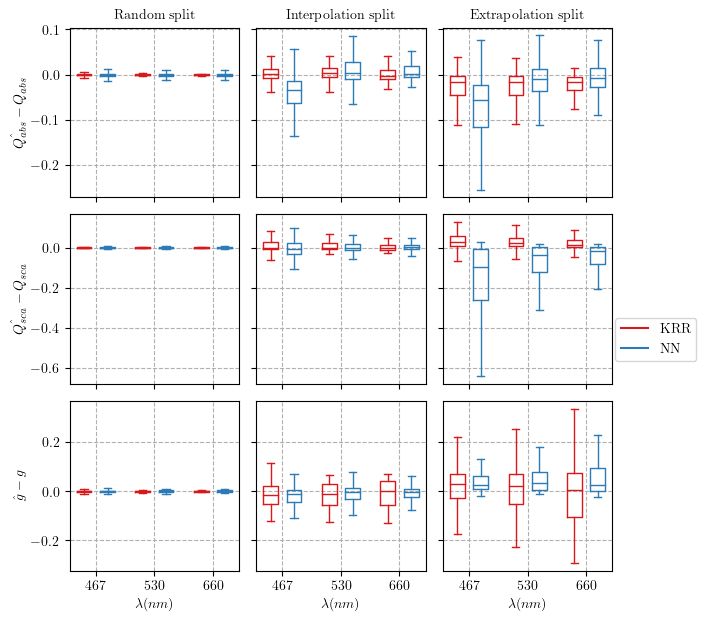

In [36]:
import os

os.makedirs('boxplots', exist_ok=True)

create_boxplots(df_random, df_extrapol, df_interpol, 'wavelength')

In [37]:
def create_boxplots(df_random, df_extrapol, df_interpol, feature_x):
    fig, axs = plt.subplots(3, 3, figsize= (1*text_width, 0.9*text_width), sharex='col', sharey='row')
    
    data_KRR=[]
    data_NN=[]
    ticks=[]
    lower_val=1.5
    upper_val=1.7
    mstm_values=df_random[(df_random[feature_x]>=lower_val) &(df_random[feature_x]<=upper_val)]['q_abs']
    KRR_values=df_random[(df_random[feature_x]>=lower_val) &(df_random[feature_x]<=upper_val)]['q_abs_pred_KRR']
    NN_values=df_random[(df_random[feature_x]>=lower_val) &(df_random[feature_x]<=upper_val)]['q_abs_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}-{upper_val}')
    lower_val=1.7
    upper_val=2.3
    for i in range(0,2):
        mstm_values=df_random[(df_random[feature_x]>lower_val) &(df_random[feature_x]<=upper_val)]['q_abs']
        KRR_values=df_random[(df_random[feature_x]>lower_val) &(df_random[feature_x]<=upper_val)]['q_abs_pred_KRR']
        NN_values=df_random[(df_random[feature_x]>lower_val) &(df_random[feature_x]<=upper_val)]['q_abs_pred_NN']
        l1=KRR_values.to_numpy()-mstm_values
        l2=NN_values.to_numpy()-mstm_values
        data_KRR.append(l1)
        data_NN.append(l2)
        ticks.append(f'{lower_val+0.2}-{upper_val}')
        lower_val=2.3
        upper_val=2.9
    
    # Creating plot
    bpl=axs[0,0].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[0,0].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_NN)))*2.0+0.4, sym="")
    axs[0,0].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[0,0].plot([], c='#D7191C')
    axs[0,0].plot([], c='#2C7BB6')
    axs[0,0].set_xticks(range(0, len(ticks) * 2, 2), ticks)
    axs[0,0].set(ylabel='$\hat{Q}_{abs}-Q_{abs}$')
    axs[0,0].title.set_text('Random split')
    
    
    
    
    ########
    data_KRR=[]
    data_NN=[]
    ticks=[]
    lower_val=2.1
#     upper_val=1.9
    mstm_values=df_interpol[(df_interpol[feature_x]==lower_val)]['q_abs']
    KRR_values=df_interpol[(df_interpol[feature_x]==lower_val)]['q_abs_pred_KRR']
    NN_values=df_interpol[(df_interpol[feature_x]==lower_val)]['q_abs_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}')
    lower_val=2.3
#     upper_val=2.5
    for i in range(0,2):
        mstm_values=df_interpol[(df_interpol[feature_x]==lower_val)]['q_abs']
        KRR_values=df_interpol[(df_interpol[feature_x]==lower_val)]['q_abs_pred_KRR']
        NN_values=df_interpol[(df_interpol[feature_x]==lower_val)]['q_abs_pred_NN']
        l1=KRR_values.to_numpy()-mstm_values
        l2=NN_values.to_numpy()-mstm_values
        data_KRR.append(l1)
        data_NN.append(l2)
        ticks.append(f'{lower_val}')
        lower_val=2.5
        
    
    # Creating plot
    bpl=axs[0,1].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[0,1].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_NN)))*2.0+0.4, sym="")
    axs[0,1].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[0,1].plot([], c='#D7191C', label='KRR')
    axs[0,1].plot([], c='#2C7BB6', label='ANN')
    axs[0,1].set_xticks(range(0, len(ticks) * 2, 2), ticks)
    axs[0,1].title.set_text('Interpolation split')
#     axs[0,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ######
    data_KRR=[]
    data_NN=[]
    ticks=[]
    lower_val=2.7
#     upper_val=1.7
    mstm_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['q_abs']
    KRR_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['q_abs_pred_KRR']
    NN_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['q_abs_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}')
#     lower_val=2.9
    lower_val=2.9
    for i in range(0,1):
        mstm_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['q_abs']
        KRR_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['q_abs_pred_KRR']
        NN_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['q_abs_pred_NN']
        l1=KRR_values.to_numpy()-mstm_values
        l2=NN_values.to_numpy()-mstm_values
        data_KRR.append(l1)
        data_NN.append(l2)
        ticks.append(f'{lower_val}')
#         lower_val=2.3
#         upper_val=2.9
    
    # Creating plot
    bpl=axs[0,2].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[0,2].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_NN)))*2.0+0.4, sym="")
    axs[0,2].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[0,2].plot([], c='#D7191C')
    axs[0,2].plot([], c='#2C7BB6')
    axs[0,2].set_xticks(range(0, len(ticks) * 2, 2), ticks)
    axs[0,2].title.set_text('Extrapolation split')
    ##################################################################
    data_KRR=[]
    data_NN=[]
    ticks=[]
    lower_val=1.5
    upper_val=1.7
    mstm_values=df_random[(df_random[feature_x]>=lower_val) &(df_random[feature_x]<=upper_val)]['q_sca']
    KRR_values=df_random[(df_random[feature_x]>=lower_val) &(df_random[feature_x]<=upper_val)]['q_sca_pred_KRR']
    NN_values=df_random[(df_random[feature_x]>=lower_val) &(df_random[feature_x]<=upper_val)]['q_sca_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}-{upper_val}')
    lower_val=1.7
    upper_val=2.3
    for i in range(0,2):
        mstm_values=df_random[(df_random[feature_x]>lower_val) &(df_random[feature_x]<=upper_val)]['q_sca']
        KRR_values=df_random[(df_random[feature_x]>lower_val) &(df_random[feature_x]<=upper_val)]['q_sca_pred_KRR']
        NN_values=df_random[(df_random[feature_x]>lower_val) &(df_random[feature_x]<=upper_val)]['q_sca_pred_NN']
        l1=KRR_values.to_numpy()-mstm_values
        l2=NN_values.to_numpy()-mstm_values
        data_KRR.append(l1)
        data_NN.append(l2)
        ticks.append(f'{lower_val+0.2}-{upper_val}')
        lower_val=2.3
        upper_val=2.9
    
    # Creating plot
    bpl=axs[1,0].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[1,0].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_NN)))*2.0+0.4, sym="")
    axs[1,0].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[1,0].plot([], c='#D7191C')
    axs[1,0].plot([], c='#2C7BB6')
    axs[1,0].set_xticks(range(0, len(ticks) * 2, 2), ticks)
    axs[1,0].set(ylabel='$\hat{Q}_{sca}-Q_{sca}$')
    
    
    
    
    ########
    data_KRR=[]
    data_NN=[]
    ticks=[]
    lower_val=2.1
#     upper_val=1.9
    mstm_values=df_interpol[(df_interpol[feature_x]==lower_val)]['q_sca']
    KRR_values=df_interpol[(df_interpol[feature_x]==lower_val)]['q_sca_pred_KRR']
    NN_values=df_interpol[(df_interpol[feature_x]==lower_val)]['q_sca_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}')
    lower_val=2.3
#     upper_val=2.5
    for i in range(0,2):
        mstm_values=df_interpol[(df_interpol[feature_x]==lower_val)]['q_sca']
        KRR_values=df_interpol[(df_interpol[feature_x]==lower_val)]['q_sca_pred_KRR']
        NN_values=df_interpol[(df_interpol[feature_x]==lower_val)]['q_sca_pred_NN']
        l1=KRR_values.to_numpy()-mstm_values
        l2=NN_values.to_numpy()-mstm_values
        data_KRR.append(l1)
        data_NN.append(l2)
        ticks.append(f'{lower_val}')
        lower_val=2.5
    
    # Creating plot
    bpl=axs[1,1].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[1,1].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_NN)))*2.0+0.4, sym="")
    axs[1,1].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[1,1].plot([], c='#D7191C')
    axs[1,1].plot([], c='#2C7BB6')
    axs[1,1].set_xticks(range(0, len(ticks) * 2, 2), ticks)
    
    ######
    data_KRR=[]
    data_NN=[]
    ticks=[]
    lower_val=2.7
#     upper_val=1.7
    mstm_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['q_sca']
    KRR_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['q_sca_pred_KRR']
    NN_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['q_sca_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}')
#     lower_val=2.9
    lower_val=2.9
    for i in range(0,1):
        mstm_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['q_sca']
        KRR_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['q_sca_pred_KRR']
        NN_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['q_sca_pred_NN']
        l1=KRR_values.to_numpy()-mstm_values
        l2=NN_values.to_numpy()-mstm_values
        data_KRR.append(l1)
        data_NN.append(l2)
        ticks.append(f'{lower_val}')
#         lower_val=2.3
#         upper_val=2.9
    
    # Creating plot
    bpl=axs[1,2].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[1,2].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_NN)))*2.0+0.4, sym="")
    axs[1,2].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[1,2].plot([], c='#D7191C')
    axs[1,2].plot([], c='#2C7BB6')
    axs[1,2].set_xticks(range(0, len(ticks) * 2, 2), ticks)
    ################################################################################3
    data_KRR=[]
    data_NN=[]
    ticks=[]
    lower_val=1.5
    upper_val=1.7
    mstm_values=df_random[(df_random[feature_x]>=lower_val) &(df_random[feature_x]<=upper_val)]['g']
    KRR_values=df_random[(df_random[feature_x]>=lower_val) &(df_random[feature_x]<=upper_val)]['g_pred_KRR']
    NN_values=df_random[(df_random[feature_x]>=lower_val) &(df_random[feature_x]<=upper_val)]['g_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}-{upper_val}')
    lower_val=1.7
    upper_val=2.3
    for i in range(0,2):
        mstm_values=df_random[(df_random[feature_x]>lower_val) &(df_random[feature_x]<=upper_val)]['g']
        KRR_values=df_random[(df_random[feature_x]>lower_val) &(df_random[feature_x]<=upper_val)]['g_pred_KRR']
        NN_values=df_random[(df_random[feature_x]>lower_val) &(df_random[feature_x]<=upper_val)]['g_pred_NN']
        l1=KRR_values.to_numpy()-mstm_values
        l2=NN_values.to_numpy()-mstm_values
        data_KRR.append(l1)
        data_NN.append(l2)
        ticks.append(f'{lower_val+0.2}-{upper_val}')
        lower_val=2.3
        upper_val=2.9
    
    # Creating plot
    bpl=axs[2,0].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[2,0].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_NN)))*2.0+0.4, sym="")
    axs[2,0].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[2,0].plot([], c='#D7191C')
    axs[2,0].plot([], c='#2C7BB6')
    axs[2,0].set_xticks(range(0, len(ticks) * 2, 2), ticks)
    axs[2,0].set(ylabel='$\hat{g}-g$')
    axs[2,0].set(xlabel='$D_{f}$')
    
    
    
    
    ########
    data_KRR=[]
    data_NN=[]
    ticks=[]
    lower_val=2.1
#     upper_val=1.9
    mstm_values=df_interpol[(df_interpol[feature_x]==lower_val)]['g']
    KRR_values=df_interpol[(df_interpol[feature_x]==lower_val)]['g_pred_KRR']
    NN_values=df_interpol[(df_interpol[feature_x]==lower_val)]['g_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}')
    lower_val=2.3
#     upper_val=2.5
    for i in range(0,2):
        mstm_values=df_interpol[(df_interpol[feature_x]==lower_val)]['g']
        KRR_values=df_interpol[(df_interpol[feature_x]==lower_val)]['g_pred_KRR']
        NN_values=df_interpol[(df_interpol[feature_x]==lower_val)]['g_pred_NN']
        l1=KRR_values.to_numpy()-mstm_values
        l2=NN_values.to_numpy()-mstm_values
        data_KRR.append(l1)
        data_NN.append(l2)
        ticks.append(f'{lower_val}')
        lower_val=2.5
    
    # Creating plot
    bpl=axs[2,1].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[2,1].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_NN)))*2.0+0.4, sym="")
    axs[2,1].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[2,1].plot([], c='#D7191C')
    axs[2,1].plot([], c='#2C7BB6')
    axs[2,1].set_xticks(range(0, len(ticks) * 2, 2), ticks)
    axs[2,1].set(xlabel='$D_{f}$')
    ######
    data_KRR=[]
    data_NN=[]
    ticks=[]
    lower_val=2.7
#     upper_val=1.7
    mstm_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['g']
    KRR_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['g_pred_KRR']
    NN_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['g_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}')
#     lower_val=2.9
    lower_val=2.9
    for i in range(0,1):
        mstm_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['g']
        KRR_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['g_pred_KRR']
        NN_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['g_pred_NN']
        l1=KRR_values.to_numpy()-mstm_values
        l2=NN_values.to_numpy()-mstm_values
        data_KRR.append(l1)
        data_NN.append(l2)
        ticks.append(f'{lower_val}')
#         lower_val=2.3
#         upper_val=2.9
    
    # Creating plot
    bpl=axs[2,2].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[2,2].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_NN)))*2.0+0.4, sym="")
    axs[2,2].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[2,2].plot([], c='#D7191C')
    axs[2,2].plot([], c='#2C7BB6')
    axs[2,2].set_xticks(range(0, len(ticks) * 2, 2), ticks)
    axs[2,2].set(xlabel='$D_{f}$')
    fig.tight_layout()
    fig.legend(loc='upper center', bbox_to_anchor=(1.05, 0.5))
    
    fig.savefig(f"boxplots/boxplot_df.pdf", format="pdf", bbox_inches="tight")

    
    
    
   

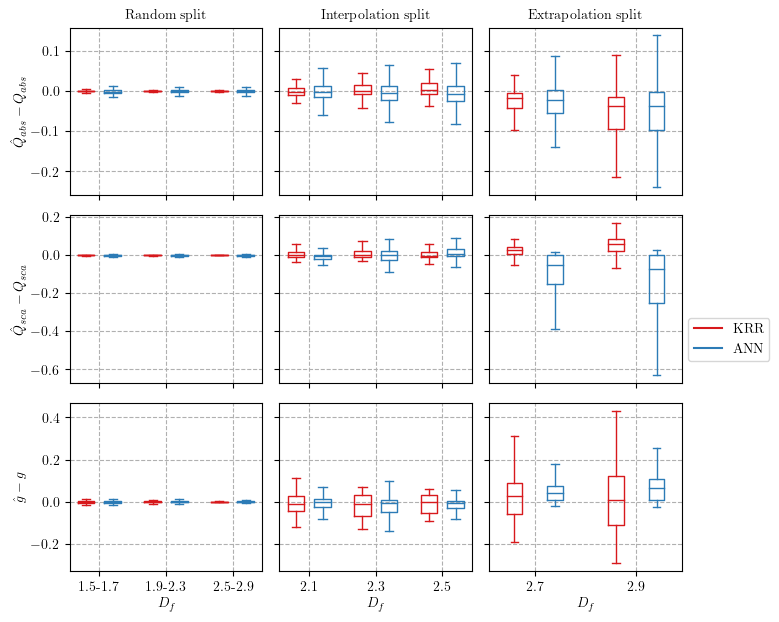

In [38]:
create_boxplots(df_random, df_extrapol, df_interpol, 'fractal_dimension')

In [39]:
def create_boxplots(df_random, df_extrapol, df_interpol, feature_x):
    fig, axs = plt.subplots(3, 3, figsize= (1*text_width, 0.9*text_width), sharex = 'col', sharey='row')
    
    data_KRR=[]
    data_NN=[]
    ticks=[]
    lower_val= 0
    upper_val=100
    mstm_values=df_random[(df_random[feature_x]>=lower_val) &(df_random[feature_x]<=upper_val)]['q_abs']
    KRR_values=df_random[(df_random[feature_x]>=lower_val) &(df_random[feature_x]<=upper_val)]['q_abs_pred_KRR']
    NN_values=df_random[(df_random[feature_x]>=lower_val) &(df_random[feature_x]<=upper_val)]['q_abs_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}-{upper_val}')
    
    
    lower_val=100
    upper_val=500
    mstm_values=df_random[(df_random[feature_x]>lower_val) &(df_random[feature_x]<=upper_val)]['q_abs']
    KRR_values=df_random[(df_random[feature_x]>lower_val) &(df_random[feature_x]<=upper_val)]['q_abs_pred_KRR']
    NN_values=df_random[(df_random[feature_x]>lower_val) &(df_random[feature_x]<=upper_val)]['q_abs_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}-{upper_val}')
    
    lower_val=500
    mstm_values=df_random[(df_random[feature_x]>lower_val)]['q_abs']
    KRR_values=df_random[(df_random[feature_x]>lower_val)]['q_abs_pred_KRR']
    NN_values=df_random[(df_random[feature_x]>lower_val)]['q_abs_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}-{upper_val}')
    
    # Creating plot
    bpl=axs[0,0].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[0,0].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0+0.4, sym="")
    axs[0,0].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[0,0].plot([], c='#D7191C')
    axs[0,0].plot([], c='#2C7BB6')
    axs[0,0].set_xticks(range(0, len(ticks) * 2, 2), ticks)
    axs[0,0].set(ylabel='$\hat{Q}_{abs}-Q_{abs}$')
    axs[0,0].title.set_text('Random split')
    
    
    
    
    ########
    data_KRR=[]
    data_NN=[]
    ticks=[]
    lower_val= 0
    upper_val=100
    mstm_values=df_interpol[(df_interpol[feature_x]>=lower_val) &(df_interpol[feature_x]<=upper_val)]['q_abs']
    KRR_values=df_interpol[(df_interpol[feature_x]>=lower_val) &(df_interpol[feature_x]<=upper_val)]['q_abs_pred_KRR']
    NN_values=df_interpol[(df_interpol[feature_x]>=lower_val) &(df_interpol[feature_x]<=upper_val)]['q_abs_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}-{upper_val}')
    
    
    lower_val=100
    upper_val=500
    mstm_values=df_interpol[(df_interpol[feature_x]>lower_val) &(df_interpol[feature_x]<=upper_val)]['q_abs']
    KRR_values=df_interpol[(df_interpol[feature_x]>lower_val) &(df_interpol[feature_x]<=upper_val)]['q_abs_pred_KRR']
    NN_values=df_interpol[(df_interpol[feature_x]>lower_val) &(df_interpol[feature_x]<=upper_val)]['q_abs_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}-{upper_val}')
    
    lower_val=500
    mstm_values=df_interpol[(df_interpol[feature_x]>lower_val)]['q_abs']
    KRR_values=df_interpol[(df_interpol[feature_x]>lower_val)]['q_abs_pred_KRR']
    NN_values=df_interpol[(df_interpol[feature_x]>lower_val)]['q_abs_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}')
        
    
    # Creating plot
    bpl=axs[0,1].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[0,1].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0+0.4, sym="")
    axs[0,1].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[0,1].plot([], c='#D7191C', label='KRR')
    axs[0,1].plot([], c='#2C7BB6', label='ANN')
    axs[0,1].set_xticks(range(0, len(ticks) * 2, 2), ticks)
    axs[0,1].title.set_text('Interpolation split')
#     axs[0,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))


    ######
    data_KRR=[]
    data_NN=[]
    ticks=[]
    lower_val= 0
    upper_val=100
    mstm_values=df_extrapol[(df_extrapol[feature_x]>=lower_val) &(df_extrapol[feature_x]<=upper_val)]['q_abs']
    KRR_values=df_extrapol[(df_extrapol[feature_x]>=lower_val) &(df_extrapol[feature_x]<=upper_val)]['q_abs_pred_KRR']
    NN_values=df_extrapol[(df_extrapol[feature_x]>=lower_val) &(df_extrapol[feature_x]<=upper_val)]['q_abs_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}-{upper_val}')
    
    
    lower_val=100
    upper_val=500
    mstm_values=df_extrapol[(df_extrapol[feature_x]>lower_val) &(df_extrapol[feature_x]<=upper_val)]['q_abs']
    KRR_values=df_extrapol[(df_extrapol[feature_x]>lower_val) &(df_extrapol[feature_x]<=upper_val)]['q_abs_pred_KRR']
    NN_values=df_extrapol[(df_extrapol[feature_x]>lower_val) &(df_extrapol[feature_x]<=upper_val)]['q_abs_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}-{upper_val}')
    
    lower_val=500
    mstm_values=df_extrapol[(df_extrapol[feature_x]>lower_val)]['q_abs']
    KRR_values=df_extrapol[(df_extrapol[feature_x]>lower_val)]['q_abs_pred_KRR']
    NN_values=df_extrapol[(df_extrapol[feature_x]>lower_val)]['q_abs_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}')
    
    # Creating plot
    bpl=axs[0,2].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[0,2].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0+0.4, sym="")
    axs[0,2].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[0,2].plot([], c='#D7191C')
    axs[0,2].plot([], c='#2C7BB6')
    axs[0,2].set_xticks(range(0, len(ticks) * 2, 2), ticks)
#     axs[0,2].set(xlabel='$D_{mob}$')
    axs[0,2].title.set_text('Extrapolation split')
    ##################################################################
    data_KRR=[]
    data_NN=[]
    ticks=[]
    lower_val= 0
    upper_val=100
    mstm_values=df_random[(df_random[feature_x]>=lower_val) &(df_random[feature_x]<=upper_val)]['q_sca']
    KRR_values=df_random[(df_random[feature_x]>=lower_val) &(df_random[feature_x]<=upper_val)]['q_sca_pred_KRR']
    NN_values=df_random[(df_random[feature_x]>=lower_val) &(df_random[feature_x]<=upper_val)]['q_sca_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}-{upper_val}')
    
    
    lower_val=100
    upper_val=500
    mstm_values=df_random[(df_random[feature_x]>lower_val) &(df_random[feature_x]<=upper_val)]['q_sca']
    KRR_values=df_random[(df_random[feature_x]>lower_val) &(df_random[feature_x]<=upper_val)]['q_sca_pred_KRR']
    NN_values=df_random[(df_random[feature_x]>lower_val) &(df_random[feature_x]<=upper_val)]['q_sca_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}-{upper_val}')
    
    lower_val=500
    mstm_values=df_random[(df_random[feature_x]>lower_val)]['q_sca']
    KRR_values=df_random[(df_random[feature_x]>lower_val)]['q_sca_pred_KRR']
    NN_values=df_random[(df_random[feature_x]>lower_val)]['q_sca_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}')
    
    # Creating plot
    bpl=axs[1,0].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[1,0].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0+0.4, sym="")
    axs[1,0].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[1,0].plot([], c='#D7191C')
    axs[1,0].plot([], c='#2C7BB6')
    axs[1,0].set_xticks(range(0, len(ticks) * 2, 2), ticks)
    axs[1,0].set(ylabel='$\hat{Q}_{sca}-Q_{sca}$')
#     axs[1,0].title.set_text('Random split')
    
    
    
    
    ########
    data_KRR=[]
    data_NN=[]
    ticks=[]
    lower_val= 0
    upper_val=100
    mstm_values=df_interpol[(df_interpol[feature_x]>=lower_val) &(df_interpol[feature_x]<=upper_val)]['q_sca']
    KRR_values=df_interpol[(df_interpol[feature_x]>=lower_val) &(df_interpol[feature_x]<=upper_val)]['q_sca_pred_KRR']
    NN_values=df_interpol[(df_interpol[feature_x]>=lower_val) &(df_interpol[feature_x]<=upper_val)]['q_sca_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}-{upper_val}')
    
    
    lower_val=100
    upper_val=500
    mstm_values=df_interpol[(df_interpol[feature_x]>lower_val) &(df_interpol[feature_x]<=upper_val)]['q_sca']
    KRR_values=df_interpol[(df_interpol[feature_x]>lower_val) &(df_interpol[feature_x]<=upper_val)]['q_sca_pred_KRR']
    NN_values=df_interpol[(df_interpol[feature_x]>lower_val) &(df_interpol[feature_x]<=upper_val)]['q_sca_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}-{upper_val}')
    
    lower_val=500
    mstm_values=df_interpol[(df_interpol[feature_x]>lower_val)]['q_sca']
    KRR_values=df_interpol[(df_interpol[feature_x]>lower_val)]['q_sca_pred_KRR']
    NN_values=df_interpol[(df_interpol[feature_x]>lower_val)]['q_sca_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}')
        
    
    # Creating plot
    bpl=axs[1,1].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[1,1].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0+0.4, sym="")
    axs[1,1].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
#     axs[1,1].plot([], c='#D7191C', label='KRR')
#     axs[1,1].plot([], c='#2C7BB6', label='NN')
    axs[1,1].set_xticks(range(0, len(ticks) * 2, 2), ticks)
#     axs[1,1].title.set_text('Interpolation split')
#     axs[0,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))


    ######
    data_KRR=[]
    data_NN=[]
    ticks=[]
    lower_val= 0
    upper_val=100
    mstm_values=df_extrapol[(df_extrapol[feature_x]>=lower_val) &(df_extrapol[feature_x]<=upper_val)]['q_sca']
    KRR_values=df_extrapol[(df_extrapol[feature_x]>=lower_val) &(df_extrapol[feature_x]<=upper_val)]['q_sca_pred_KRR']
    NN_values=df_extrapol[(df_extrapol[feature_x]>=lower_val) &(df_extrapol[feature_x]<=upper_val)]['q_sca_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}-{upper_val}')
    
    
    lower_val=100
    upper_val=500
    mstm_values=df_extrapol[(df_extrapol[feature_x]>lower_val) &(df_extrapol[feature_x]<=upper_val)]['q_sca']
    KRR_values=df_extrapol[(df_extrapol[feature_x]>lower_val) &(df_extrapol[feature_x]<=upper_val)]['q_sca_pred_KRR']
    NN_values=df_extrapol[(df_extrapol[feature_x]>lower_val) &(df_extrapol[feature_x]<=upper_val)]['q_sca_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}-{upper_val}')
    
    lower_val=500
    mstm_values=df_extrapol[(df_extrapol[feature_x]>lower_val)]['q_sca']
    KRR_values=df_extrapol[(df_extrapol[feature_x]>lower_val)]['q_sca_pred_KRR']
    NN_values=df_extrapol[(df_extrapol[feature_x]>lower_val)]['q_sca_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}')
    
    # Creating plot
    bpl=axs[1,2].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[1,2].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0+0.4, sym="")
    axs[1,2].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[1,2].plot([], c='#D7191C')
    axs[1,2].plot([], c='#2C7BB6')
    axs[1,2].set_xticks(range(0, len(ticks) * 2, 2), ticks)
#     axs[1,2].set(xlabel='$D_{mob}$')
#     axs[1,2].title.set_text('Extrapolation split')
    ################################################################################3
    data_KRR=[]
    data_NN=[]
    ticks=[]
    lower_val= 0
    upper_val=100
    mstm_values=df_random[(df_random[feature_x]>=lower_val) &(df_random[feature_x]<=upper_val)]['g']
    KRR_values=df_random[(df_random[feature_x]>=lower_val) &(df_random[feature_x]<=upper_val)]['g_pred_KRR']
    NN_values=df_random[(df_random[feature_x]>=lower_val) &(df_random[feature_x]<=upper_val)]['g_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}-{upper_val}')
    
    
    lower_val=100
    upper_val=500
    mstm_values=df_random[(df_random[feature_x]>lower_val) &(df_random[feature_x]<=upper_val)]['g']
    KRR_values=df_random[(df_random[feature_x]>lower_val) &(df_random[feature_x]<=upper_val)]['g_pred_KRR']
    NN_values=df_random[(df_random[feature_x]>lower_val) &(df_random[feature_x]<=upper_val)]['g_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}-{upper_val}')
    
    lower_val=500
    mstm_values=df_random[(df_random[feature_x]>lower_val)]['g']
    KRR_values=df_random[(df_random[feature_x]>lower_val)]['g_pred_KRR']
    NN_values=df_random[(df_random[feature_x]>lower_val)]['g_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}')
    
    # Creating plot
    bpl=axs[2,0].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[2,0].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0+0.4, sym="")
    axs[2,0].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[2,0].plot([], c='#D7191C')
    axs[2,0].plot([], c='#2C7BB6')
    axs[2,0].set_xticks(range(0, len(ticks) * 2, 2), ticks)
    axs[2,0].set(ylabel='$\hat{g}- g$')
    axs[2,0].set(xlabel='$D_{mob}$')
#     axs[2,0].title.set_text('Random split')
    
    
    
    
    ########
    data_KRR=[]
    data_NN=[]
    ticks=[]
    lower_val= 0
    upper_val=100
    mstm_values=df_interpol[(df_interpol[feature_x]>=lower_val) &(df_interpol[feature_x]<=upper_val)]['g']
    KRR_values=df_interpol[(df_interpol[feature_x]>=lower_val) &(df_interpol[feature_x]<=upper_val)]['g_pred_KRR']
    NN_values=df_interpol[(df_interpol[feature_x]>=lower_val) &(df_interpol[feature_x]<=upper_val)]['g_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}-{upper_val}')
    
    
    lower_val=100
    upper_val=500
    mstm_values=df_interpol[(df_interpol[feature_x]>lower_val) &(df_interpol[feature_x]<=upper_val)]['g']
    KRR_values=df_interpol[(df_interpol[feature_x]>lower_val) &(df_interpol[feature_x]<=upper_val)]['g_pred_KRR']
    NN_values=df_interpol[(df_interpol[feature_x]>lower_val) &(df_interpol[feature_x]<=upper_val)]['g_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}-{upper_val}')
    
    lower_val=500
    mstm_values=df_interpol[(df_interpol[feature_x]>lower_val)]['g']
    KRR_values=df_interpol[(df_interpol[feature_x]>lower_val)]['g_pred_KRR']
    NN_values=df_interpol[(df_interpol[feature_x]>lower_val)]['g_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}')
        
    
    # Creating plot
    bpl=axs[2,1].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[2,1].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0+0.4, sym="")
    axs[2,1].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[2,1].set(xlabel='$D_{mob}$')
#     axs[2,1].plot([], c='#D7191C', label='KRR')
#     axs[2,1].plot([], c='#2C7BB6', label='NN')
    axs[2,1].set_xticks(range(0, len(ticks) * 2, 2), ticks)
#     axs[2,1].title.set_text('Interpolation split')
#     axs[0,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))


    ######
    data_KRR=[]
    data_NN=[]
    ticks=[]
    lower_val= 0
    upper_val=100
    mstm_values=df_extrapol[(df_extrapol[feature_x]>=lower_val) &(df_extrapol[feature_x]<=upper_val)]['g']
    KRR_values=df_extrapol[(df_extrapol[feature_x]>=lower_val) &(df_extrapol[feature_x]<=upper_val)]['g_pred_KRR']
    NN_values=df_extrapol[(df_extrapol[feature_x]>=lower_val) &(df_extrapol[feature_x]<=upper_val)]['g_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}-{upper_val}')
    
    
    lower_val=100
    upper_val=500
    mstm_values=df_extrapol[(df_extrapol[feature_x]>lower_val) &(df_extrapol[feature_x]<=upper_val)]['g']
    KRR_values=df_extrapol[(df_extrapol[feature_x]>lower_val) &(df_extrapol[feature_x]<=upper_val)]['g_pred_KRR']
    NN_values=df_extrapol[(df_extrapol[feature_x]>lower_val) &(df_extrapol[feature_x]<=upper_val)]['g_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}-{upper_val}')
    
    lower_val=500
    mstm_values=df_extrapol[(df_extrapol[feature_x]>lower_val)]['g']
    KRR_values=df_extrapol[(df_extrapol[feature_x]>lower_val)]['g_pred_KRR']
    NN_values=df_extrapol[(df_extrapol[feature_x]>lower_val)]['g_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}')
    
    # Creating plot
    bpl=axs[2,2].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[2,2].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0+0.4, sym="")
    axs[2,2].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[2,2].plot([], c='#D7191C')
    axs[2,2].plot([], c='#2C7BB6')
    axs[2,2].set_xticks(range(0, len(ticks) * 2, 2), ticks)
#     axs[2,2].title.set_text('Extrapolation split')    
    axs[2,2].set(xlabel='$D_{mob}$')
    fig.tight_layout()
    fig.legend(loc='upper center', bbox_to_anchor=(1.05, 0.5))
    
    fig.savefig(f"boxplots/boxplot_dmob.pdf", format="pdf", bbox_inches="tight")

    
    
    
   

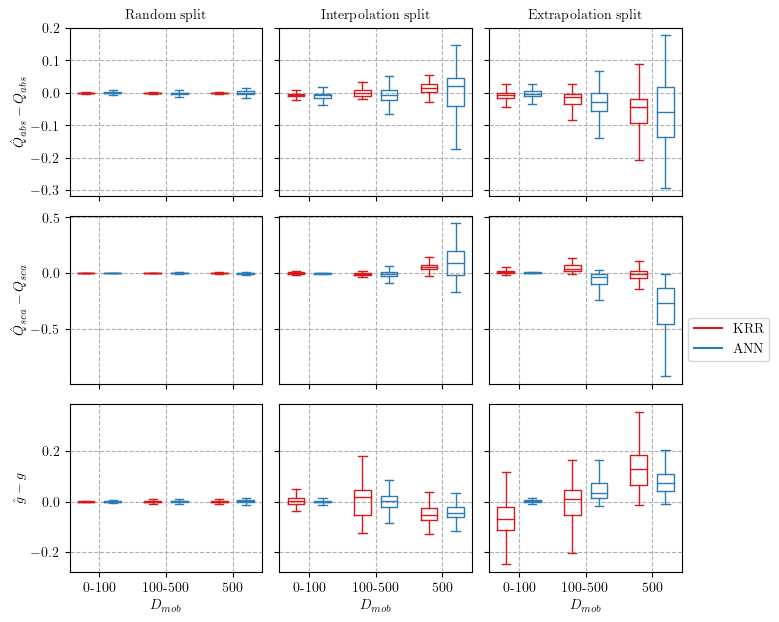

In [40]:
create_boxplots(df_random, df_extrapol, df_interpol, 'equi_mobility_dia')

# Leave out foc(70,80,90) (KRR extrapolation)

In [41]:

train_set = df[(df['fraction_of_coating'] < 70)]
test_set = df[(df['fraction_of_coating'] >= 70)]
Y_train = train_set.iloc[:, 25:28]
X_train = train_set.iloc[:, :8]
Y_test = test_set.iloc[:, 25:28]
X_test = test_set.iloc[:, :8]

pt = PowerTransformer(method='box-cox')

X_test=X_test.reset_index(drop=True)
Y_test=Y_test.reset_index(drop=True)

X_train_transformed = pt.fit_transform(X_train+0.00000000001)
X_test_transformed = pt.transform(X_test+0.000000001)




print(pd.DataFrame({'cols':X_train.columns,'box_cox_lambdas':pt.lambdas_}))

regressor = KernelRidge(alpha=0.001, gamma=0.01, kernel='rbf')


model = regressor.fit(X_train_transformed,Y_train)


Y_pred = model.predict(X_test_transformed)


Y_pred_KRR = pd.DataFrame(data=Y_pred, columns=["q_abs_pred_KRR", "q_sca_pred_KRR","g_pred_KRR"])
#Y_test.reset_index(inplace=True)
#Y_test.drop('index',axis=1, inplace=True)
error = mean_absolute_error(Y_test, Y_pred_KRR, multioutput='raw_values')

# error=calculate_mean_absolute_percentage_error_multi(parameter_alpha, parameter_kernel# parameter_gamma, X_train, Y_train, X_test, Y_test, scaling_y)
print('Mean absolute error on test set: ', error)
# Running and logging model plus Early stopping



                          cols  box_cox_lambdas
0                   wavelength        -1.862685
1            fractal_dimension         0.671153
2          fraction_of_coating         0.235982
3        primary_particle_size        -5.690486
4  number_of_primary_particles         0.107323
5        vol_equi_radius_outer         0.294574
6        vol_equi_radius_inner         0.321969
7            equi_mobility_dia         0.202535
Mean absolute error on test set:  [0.03260518 0.02755033 0.04234541]


In [42]:
train_set = df[(df['fraction_of_coating'] < 70)]
test_set = df[(df['fraction_of_coating'] >= 70)]
Y_train = train_set.iloc[:, 25:28]
X_train = train_set.iloc[:, :8]
Y_test = test_set.iloc[:, 25:28]
X_test = test_set.iloc[:, :8]
X_test=X_test.reset_index(drop=True)
Y_test=Y_test.reset_index(drop=True)
pt = PowerTransformer(method='box-cox')

X_test=X_test.reset_index(drop=True)
Y_test=Y_test.reset_index(drop=True)

X_train_transformed = pt.fit_transform(X_train+0.00000000001)
X_test_transformed = pt.transform(X_test+0.000000001)


print(pd.DataFrame({'cols':X_train.columns,'box_cox_lambdas':pt.lambdas_}))


model = load_model('../model_files/best_model_extra_foc.hdf5')
Y_pred_NN = model.predict(X_test_transformed)

Y_test = pd.DataFrame(data=Y_test, columns=["q_abs", "q_sca","g"])

Y_pred_NN = pd.DataFrame(data=Y_pred_NN, columns=["q_abs_pred_NN", "q_sca_pred_NN","g_pred_NN"])
#Y_test.reset_index(inplace=True)
#Y_test.drop('index',axis=1, inplace=True)
error = mean_absolute_error(Y_test, Y_pred_NN, multioutput='raw_values')

# error=calculate_mean_absolute_percentage_error_multi(parameter_alpha, parameter_kernel# parameter_gamma, X_train, Y_train, X_test, Y_test, scaling_y)
print('Mean absolute error on test set: ', error)

                          cols  box_cox_lambdas
0                   wavelength        -1.862685
1            fractal_dimension         0.671153
2          fraction_of_coating         0.235982
3        primary_particle_size        -5.690486
4  number_of_primary_particles         0.107323
5        vol_equi_radius_outer         0.294574
6        vol_equi_radius_inner         0.321969
7            equi_mobility_dia         0.202535
Mean absolute error on test set:  [0.05204635 0.05189579 0.03170993]


In [43]:
df_extrapol=pd.concat([X_test, Y_test, Y_pred_KRR, Y_pred_NN], axis =1)
df_extrapol= df_extrapol.sort_values(by=['equi_mobility_dia'])
df_extrapol=df_extrapol.reset_index(drop=True)
df_extrapol

,wavelength,fractal_dimension,fraction_of_coating,primary_particle_size,number_of_primary_particles,vol_equi_radius_outer,vol_equi_radius_inner,equi_mobility_dia,q_abs,q_sca,g,q_abs_pred_KRR,q_sca_pred_KRR,g_pred_KRR,q_abs_pred_NN,q_sca_pred_NN,g_pred_NN
0,660,1.5,70,22.4,0.5,17.778892,11.905508,24.988962,0.11691,0.000389,0.003798,0.051262,-0.012936,0.000919,0.106481,-0.006637,-0.008744
1,467,1.7,70,22.4,0.5,17.778892,11.905508,24.988962,0.19030,0.001535,0.007075,0.146685,-0.005247,0.003020,0.171270,-0.003813,0.001049
2,467,2.1,70,22.4,0.5,17.778892,11.905508,24.988962,0.19030,0.001535,0.007075,0.151439,-0.005961,0.002118,0.170566,-0.003271,0.002028
3,467,1.5,70,22.4,0.5,17.778892,11.905508,24.988962,0.19030,0.001535,0.007075,0.143025,-0.002875,-0.002452,0.169650,-0.003713,0.000458
4,530,2.9,70,22.4,0.5,17.778892,11.905508,24.988962,0.15654,0.000930,0.005690,0.120206,0.014289,0.050415,0.147059,-0.003553,-0.002668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4021,660,2.5,90,29.0,1000.0,290.000000,150.000000,1561.074003,0.45801,1.003600,0.900450,0.494513,0.973612,0.951833,0.736483,0.882196,0.842235
4022,467,2.1,90,29.0,1000.0,290.000000,150.000000,1561.074003,1.48740,1.534600,0.820130,1.353209,1.325952,0.821261,1.388948,1.300322,0.856149
4023,530,1.9,90,29.0,1000.0,290.000000,150.000000,1561.074003,0.86400,0.673490,0.732260,0.911299,0.750314,0.806188,1.057870,0.730218,0.786027
4024,467,2.7,90,29.0,1000.0,290.000000,150.000000,1561.074003,1.36780,2.809100,0.925200,1.259839,2.282071,0.877957,1.385630,2.044312,0.984371


# Leave out FOC(30,40,50) (KRR)

In [44]:

train_set = df[(df['fraction_of_coating'] < 30)|(df['fraction_of_coating'] > 50)]
test_set = df[(df['fraction_of_coating'] >= 30)&(df['fraction_of_coating'] <= 50)]
Y_train = train_set.iloc[:, 25:28]
X_train = train_set.iloc[:, :8]
Y_test = test_set.iloc[:, 25:28]
X_test = test_set.iloc[:, :8]

pt = PowerTransformer(method='box-cox')

X_test=X_test.reset_index(drop=True)
Y_test=Y_test.reset_index(drop=True)

X_train_transformed = pt.fit_transform(X_train+0.00000000001)
X_test_transformed = pt.transform(X_test+0.000000001)




print(pd.DataFrame({'cols':X_train.columns,'box_cox_lambdas':pt.lambdas_}))

regressor = KernelRidge(alpha=0.001, gamma=0.01, kernel='rbf')


model = regressor.fit(X_train_transformed,Y_train)


Y_pred = model.predict(X_test_transformed)


Y_pred_KRR = pd.DataFrame(data=Y_pred, columns=["q_abs_pred_KRR", "q_sca_pred_KRR","g_pred_KRR"])
#Y_test.reset_index(inplace=True)
#Y_test.drop('index',axis=1, inplace=True)
error = mean_absolute_error(Y_test, Y_pred_KRR, multioutput='raw_values')

# error=calculate_mean_absolute_percentage_error_multi(parameter_alpha, parameter_kernel# parameter_gamma, X_train, Y_train, X_test, Y_test, scaling_y)
print('Mean absolute error on test set: ', error)
# Running and logging model plus Early stopping



                          cols  box_cox_lambdas
0                   wavelength        -1.865720
1            fractal_dimension         0.672591
2          fraction_of_coating         0.212463
3        primary_particle_size        -3.412923
4  number_of_primary_particles         0.107311
5        vol_equi_radius_outer         0.193047
6        vol_equi_radius_inner         0.321933
7            equi_mobility_dia         0.169826
Mean absolute error on test set:  [0.00676081 0.00919005 0.0269343 ]


In [45]:
train_set = df[(df['fraction_of_coating'] < 30)|(df['fraction_of_coating'] > 50)]
test_set = df[(df['fraction_of_coating'] >= 30)&(df['fraction_of_coating'] <= 50)]
Y_train = train_set.iloc[:, 25:28]
X_train = train_set.iloc[:, :8]
Y_test = test_set.iloc[:, 25:28]
X_test = test_set.iloc[:, :8]
X_test=X_test.reset_index(drop=True)
Y_test=Y_test.reset_index(drop=True)
pt = PowerTransformer(method='box-cox')

X_test=X_test.reset_index(drop=True)
Y_test=Y_test.reset_index(drop=True)

X_train_transformed = pt.fit_transform(X_train+0.00000000001)
X_test_transformed = pt.transform(X_test+0.000000001)


print(pd.DataFrame({'cols':X_train.columns,'box_cox_lambdas':pt.lambdas_}))


model = load_model('../model_files/best_model_intra_foc.hdf5')
Y_pred_NN = model.predict(X_test_transformed)

Y_test = pd.DataFrame(data=Y_test, columns=["q_abs", "q_sca","g"])

Y_pred_NN = pd.DataFrame(data=Y_pred_NN, columns=["q_abs_pred_NN", "q_sca_pred_NN","g_pred_NN"])
#Y_test.reset_index(inplace=True)
#Y_test.drop('index',axis=1, inplace=True)
error = mean_absolute_error(Y_test, Y_pred_NN, multioutput='raw_values')

# error=calculate_mean_absolute_percentage_error_multi(parameter_alpha, parameter_kernel# parameter_gamma, X_train, Y_train, X_test, Y_test, scaling_y)
print('Mean absolute error on test set: ', error)

                          cols  box_cox_lambdas
0                   wavelength        -1.865720
1            fractal_dimension         0.672591
2          fraction_of_coating         0.212463
3        primary_particle_size        -3.412923
4  number_of_primary_particles         0.107311
5        vol_equi_radius_outer         0.193047
6        vol_equi_radius_inner         0.321933
7            equi_mobility_dia         0.169826
Mean absolute error on test set:  [0.01956029 0.01467286 0.02181598]


In [46]:
df_interpol=pd.concat([X_test, Y_test, Y_pred_KRR, Y_pred_NN], axis =1)
df_interpol= df_interpol.sort_values(by=['equi_mobility_dia'])
df_interpol=df_interpol.reset_index(drop=True)
df_interpol

,wavelength,fractal_dimension,fraction_of_coating,primary_particle_size,number_of_primary_particles,vol_equi_radius_outer,vol_equi_radius_inner,equi_mobility_dia,q_abs,q_sca,g,q_abs_pred_KRR,q_sca_pred_KRR,g_pred_KRR,q_abs_pred_NN,q_sca_pred_NN,g_pred_NN
0,660,1.5,30,16.9,0.5,13.413539,11.905508,18.853279,0.11691,0.000389,0.003798,0.087137,-0.002079,0.017701,0.104959,-0.002933,-0.000693
1,660,2.1,30,16.9,0.5,13.413539,11.905508,18.853279,0.11691,0.000389,0.003798,0.120102,-0.018139,-0.001944,0.101896,-0.004363,-0.000840
2,660,2.3,30,16.9,0.5,13.413539,11.905508,18.853279,0.11691,0.000389,0.003798,0.125238,-0.014166,0.005792,0.102473,-0.004616,-0.001372
3,660,2.5,30,16.9,0.5,13.413539,11.905508,18.853279,0.11691,0.000389,0.003798,0.127424,-0.006190,0.026216,0.102896,-0.004677,-0.001510
4,660,2.7,30,16.9,0.5,13.413539,11.905508,18.853279,0.11691,0.000389,0.003798,0.126764,0.005288,0.061609,0.102755,-0.004614,-0.001384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4022,660,2.7,50,18.9,1000.0,189.000000,150.000000,1017.389609,0.96202,0.931180,0.780500,0.969463,0.920508,0.800565,1.014498,0.970350,0.765477
4023,530,2.5,50,18.9,1000.0,189.000000,150.000000,1017.389609,1.25820,1.037000,0.878560,1.261950,1.029786,0.868595,1.299161,1.072905,0.873505
4024,530,2.3,50,18.9,1000.0,189.000000,150.000000,1017.389609,1.27260,0.771920,0.861930,1.265398,0.789440,0.854804,1.311003,0.813926,0.872500
4025,467,1.5,50,18.9,1000.0,189.000000,150.000000,1017.389609,1.81220,0.548720,0.620870,1.813874,0.560176,0.579091,1.807121,0.633800,0.672052


In [47]:
def create_boxplots(df_random, df_extrapol, df_interpol, feature_x):
    fig, axs = plt.subplots(3, 3, figsize= (1*text_width, 0.9*text_width), sharex='col', sharey='row')
    
    data_KRR=[]
    data_NN=[]
    ticks=[]
    lower_val=0
    upper_val=25
    mstm_values=df_random[(df_random[feature_x]>=lower_val) &(df_random[feature_x]<=upper_val)]['q_abs']
    KRR_values=df_random[(df_random[feature_x]>=lower_val) &(df_random[feature_x]<=upper_val)]['q_abs_pred_KRR']
    NN_values=df_random[(df_random[feature_x]>=lower_val) &(df_random[feature_x]<=upper_val)]['q_abs_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}-{upper_val}')
    lower_val=25
    upper_val=50
    for i in range(0,2):
        mstm_values=df_random[(df_random[feature_x]>lower_val) &(df_random[feature_x]<=upper_val)]['q_abs']
        KRR_values=df_random[(df_random[feature_x]>lower_val) &(df_random[feature_x]<=upper_val)]['q_abs_pred_KRR']
        NN_values=df_random[(df_random[feature_x]>lower_val) &(df_random[feature_x]<=upper_val)]['q_abs_pred_NN']
        l1=KRR_values.to_numpy()-mstm_values
        l2=NN_values.to_numpy()-mstm_values
        data_KRR.append(l1)
        data_NN.append(l2)
        ticks.append(f'{lower_val+5}-{upper_val}')
        lower_val=55
        upper_val=90
    
    # Creating plot
    bpl=axs[0,0].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[0,0].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_NN)))*2.0+0.4, sym="")
    axs[0,0].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[0,0].plot([], c='#D7191C')
    axs[0,0].plot([], c='#2C7BB6')
    axs[0,0].set_xticks(range(0, len(ticks) * 2, 2), ticks)
    axs[0,0].set(ylabel='$\hat{Q_{abs}}-Q_{abs}$')
    axs[0,0].title.set_text('Random split')

    
    
   
    ########
    data_KRR=[]
    data_NN=[]
    ticks=[]
    lower_val=30
#     upper_val=1.9
    mstm_values=df_interpol[(df_interpol[feature_x]==lower_val)]['q_abs']
    KRR_values=df_interpol[(df_interpol[feature_x]==lower_val)]['q_abs_pred_KRR']
    NN_values=df_interpol[(df_interpol[feature_x]==lower_val)]['q_abs_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}')
    lower_val=40
#     upper_val=2.5
    for i in range(0,2):
        mstm_values=df_interpol[(df_interpol[feature_x]==lower_val)]['q_abs']
        KRR_values=df_interpol[(df_interpol[feature_x]==lower_val)]['q_abs_pred_KRR']
        NN_values=df_interpol[(df_interpol[feature_x]==lower_val)]['q_abs_pred_NN']
        l1=KRR_values.to_numpy()-mstm_values
        l2=NN_values.to_numpy()-mstm_values
        data_KRR.append(l1)
        data_NN.append(l2)
        ticks.append(f'{lower_val}')
        lower_val+=10
        
    
    # Creating plot
    bpl=axs[0,1].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[0,1].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_NN)))*2.0+0.4, sym="")
    axs[0,1].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[0,1].plot([], c='#D7191C', label='KRR')
    axs[0,1].plot([], c='#2C7BB6', label='ANN')
    axs[0,1].set_xticks(range(0, len(ticks) * 2, 2), ticks)
    axs[0,1].title.set_text('Interpolation split')
#     axs[0,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ######
    data_KRR=[]
    data_NN=[]
    ticks=[]
    lower_val=70
#     upper_val=1.7
    mstm_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['q_abs']
    KRR_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['q_abs_pred_KRR']
    NN_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['q_abs_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}')
    lower_val=80
#     upper_val=70
    for i in range(0,2):
        mstm_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['q_abs']
        KRR_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['q_abs_pred_KRR']
        NN_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['q_abs_pred_NN']
        l1=KRR_values.to_numpy()-mstm_values
        l2=NN_values.to_numpy()-mstm_values
        data_KRR.append(l1)
        data_NN.append(l2)
        ticks.append(f'{lower_val}')
        lower_val+=10
#         upper_val=2.9
    
    # Creating plot
    bpl=axs[0,2].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[0,2].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_NN)))*2.0+0.4, sym="")
    axs[0,2].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[0,2].plot([], c='#D7191C')
    axs[0,2].plot([], c='#2C7BB6')
    axs[0,2].set_xticks(range(0, len(ticks) * 2, 2), ticks)
    axs[0,2].title.set_text('Extrapolation split')
    
    ##################################################################
    data_KRR=[]
    data_NN=[]
    ticks=[]
    lower_val=0
    upper_val=25
    mstm_values=df_random[(df_random[feature_x]>=lower_val) &(df_random[feature_x]<=upper_val)]['q_sca']
    KRR_values=df_random[(df_random[feature_x]>=lower_val) &(df_random[feature_x]<=upper_val)]['q_sca_pred_KRR']
    NN_values=df_random[(df_random[feature_x]>=lower_val) &(df_random[feature_x]<=upper_val)]['q_sca_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}-{upper_val}')
    lower_val=25
    upper_val=50
    for i in range(0,2):
        mstm_values=df_random[(df_random[feature_x]>lower_val) &(df_random[feature_x]<=upper_val)]['q_sca']
        KRR_values=df_random[(df_random[feature_x]>lower_val) &(df_random[feature_x]<=upper_val)]['q_sca_pred_KRR']
        NN_values=df_random[(df_random[feature_x]>lower_val) &(df_random[feature_x]<=upper_val)]['q_sca_pred_NN']
        l1=KRR_values.to_numpy()-mstm_values
        l2=NN_values.to_numpy()-mstm_values
        data_KRR.append(l1)
        data_NN.append(l2)
        ticks.append(f'{lower_val+5}-{upper_val}')
        lower_val=55
        upper_val=90
    
    # Creating plot
    bpl=axs[1,0].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[1,0].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_NN)))*2.0+0.4, sym="")
    axs[1,0].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[1,0].plot([], c='#D7191C')
    axs[1,0].plot([], c='#2C7BB6')
    axs[1,0].set_xticks(range(0, len(ticks) * 2, 2), ticks)
    axs[1,0].set(ylabel='$\hat{Q_{sca}}-Q_{sca}$')
    
    
    
    
    ########
    data_KRR=[]
    data_NN=[]
    ticks=[]
    lower_val=30
#     upper_val=1.9
    mstm_values=df_interpol[(df_interpol[feature_x]==lower_val)]['q_sca']
    KRR_values=df_interpol[(df_interpol[feature_x]==lower_val)]['q_sca_pred_KRR']
    NN_values=df_interpol[(df_interpol[feature_x]==lower_val)]['q_sca_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}')
    lower_val=40
#     upper_val=2.5
    for i in range(0,2):
        mstm_values=df_interpol[(df_interpol[feature_x]==lower_val)]['q_sca']
        KRR_values=df_interpol[(df_interpol[feature_x]==lower_val)]['q_sca_pred_KRR']
        NN_values=df_interpol[(df_interpol[feature_x]==lower_val)]['q_sca_pred_NN']
        l1=KRR_values.to_numpy()-mstm_values
        l2=NN_values.to_numpy()-mstm_values
        data_KRR.append(l1)
        data_NN.append(l2)
        ticks.append(f'{lower_val}')
        lower_val+=10
        
    
    # Creating plot
    bpl=axs[1,1].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[1,1].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_NN)))*2.0+0.4, sym="")
    axs[1,1].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[1,1].set_xticks(range(0, len(ticks) * 2, 2), ticks)
#     axs[0,2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ######
    data_KRR=[]
    data_NN=[]
    ticks=[]
    lower_val=70
#     upper_val=1.7
    mstm_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['q_sca']
    KRR_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['q_sca_pred_KRR']
    NN_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['q_sca_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}')
    lower_val=80
#     upper_val=70
    for i in range(0,2):
        mstm_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['q_sca']
        KRR_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['q_sca_pred_KRR']
        NN_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['q_sca_pred_NN']
        l1=KRR_values.to_numpy()-mstm_values
        l2=NN_values.to_numpy()-mstm_values
        data_KRR.append(l1)
        data_NN.append(l2)
        ticks.append(f'{lower_val}')
        lower_val+=10
#         upper_val=2.9
    
    # Creating plot
    bpl=axs[1,2].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[1,2].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_NN)))*2.0+0.4, sym="")
    axs[1,2].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[1,2].plot([], c='#D7191C')
    axs[1,2].plot([], c='#2C7BB6')
    axs[1,2].set_xticks(range(0, len(ticks) * 2, 2), ticks)
    ##################################################################
    data_KRR=[]
    data_NN=[]
    ticks=[]
    lower_val=0
    upper_val=25
    mstm_values=df_random[(df_random[feature_x]>=lower_val) &(df_random[feature_x]<=upper_val)]['g']
    KRR_values=df_random[(df_random[feature_x]>=lower_val) &(df_random[feature_x]<=upper_val)]['g_pred_KRR']
    NN_values=df_random[(df_random[feature_x]>=lower_val) &(df_random[feature_x]<=upper_val)]['g_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}-{upper_val}')
    lower_val=25
    upper_val=50
    for i in range(0,2):
        mstm_values=df_random[(df_random[feature_x]>lower_val) &(df_random[feature_x]<=upper_val)]['g']
        KRR_values=df_random[(df_random[feature_x]>lower_val) &(df_random[feature_x]<=upper_val)]['g_pred_KRR']
        NN_values=df_random[(df_random[feature_x]>lower_val) &(df_random[feature_x]<=upper_val)]['g_pred_NN']
        l1=KRR_values.to_numpy()-mstm_values
        l2=NN_values.to_numpy()-mstm_values
        data_KRR.append(l1)
        data_NN.append(l2)
        ticks.append(f'{lower_val+5}-{upper_val}')
        lower_val=55
        upper_val=90
    
    # Creating plot
    bpl=axs[2,0].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[2,0].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_NN)))*2.0+0.4, sym="")
    axs[2,0].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[2,0].plot([], c='#D7191C')
    axs[2,0].plot([], c='#2C7BB6')
    axs[2,0].set_xticks(range(0, len(ticks) * 2, 2), ticks)
    axs[2,0].set(ylabel='$\hat{g}-g$')
    axs[2,0].set(xlabel='$f_{coating}(\%)$')
    
    
    
    
    ########
    data_KRR=[]
    data_NN=[]
    ticks=[]
    lower_val=30
#     upper_val=1.9
    mstm_values=df_interpol[(df_interpol[feature_x]==lower_val)]['g']
    KRR_values=df_interpol[(df_interpol[feature_x]==lower_val)]['g_pred_KRR']
    NN_values=df_interpol[(df_interpol[feature_x]==lower_val)]['g_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}')
    lower_val=40
#     upper_val=2.5
    for i in range(0,2):
        mstm_values=df_interpol[(df_interpol[feature_x]==lower_val)]['g']
        KRR_values=df_interpol[(df_interpol[feature_x]==lower_val)]['g_pred_KRR']
        NN_values=df_interpol[(df_interpol[feature_x]==lower_val)]['g_pred_NN']
        l1=KRR_values.to_numpy()-mstm_values
        l2=NN_values.to_numpy()-mstm_values
        data_KRR.append(l1)
        data_NN.append(l2)
        ticks.append(f'{lower_val}')
        lower_val+=10
        
    
    # Creating plot
    bpl=axs[2,1].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[2,1].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_NN)))*2.0+0.4, sym="")
    axs[2,1].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[2,1].set_xticks(range(0, len(ticks) * 2, 2), ticks)
    axs[2,1].set(xlabel='$f_{coating}(\%)$')
#     axs[0,2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ######
    data_KRR=[]
    data_NN=[]
    ticks=[]
    lower_val=70
#     upper_val=1.7
    mstm_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['g']
    KRR_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['g_pred_KRR']
    NN_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['g_pred_NN']
    l1=KRR_values.to_numpy()-mstm_values
    l2=NN_values.to_numpy()-mstm_values
    data_KRR.append(l1)
    data_NN.append(l2)
    ticks.append(f'{lower_val}')
    lower_val=80
#     upper_val=70
    for i in range(0,2):
        mstm_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['g']
        KRR_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['g_pred_KRR']
        NN_values=df_extrapol[(df_extrapol[feature_x]==lower_val)]['g_pred_NN']
        l1=KRR_values.to_numpy()-mstm_values
        l2=NN_values.to_numpy()-mstm_values
        data_KRR.append(l1)
        data_NN.append(l2)
        ticks.append(f'{lower_val}')
        lower_val+=10
#         upper_val=2.9
    
    # Creating plot
    bpl=axs[2,2].boxplot(data_KRR, labels=ticks, positions=np.array(range(len(data_KRR)))*2.0-0.4, sym="")
    bpr=axs[2,2].boxplot(data_NN, labels=ticks, positions=np.array(range(len(data_NN)))*2.0+0.4, sym="")
    axs[2,2].grid(linestyle="dashed")
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')
    axs[2,2].plot([], c='#D7191C')
    axs[2,2].plot([], c='#2C7BB6')
    axs[2,2].set_xticks(range(0, len(ticks) * 2, 2), ticks)
    axs[2,2].set(xlabel='$f_{coating}(\%)$')
    ##################################################################
    fig.tight_layout()
    fig.legend(loc='upper center', bbox_to_anchor=(1.05, 0.5))
#     for ax in axs.flat:
#             ax.set(xlabel='$f_{coating}$')
    
#     # Hide x labels and tick labels for top plots and y ticks for right plots.
#     for ax in axs.flat:
#         ax.label_outer()
    fig.savefig(f"boxplots/boxplot_foc.pdf", format="pdf", bbox_inches="tight")
   
   

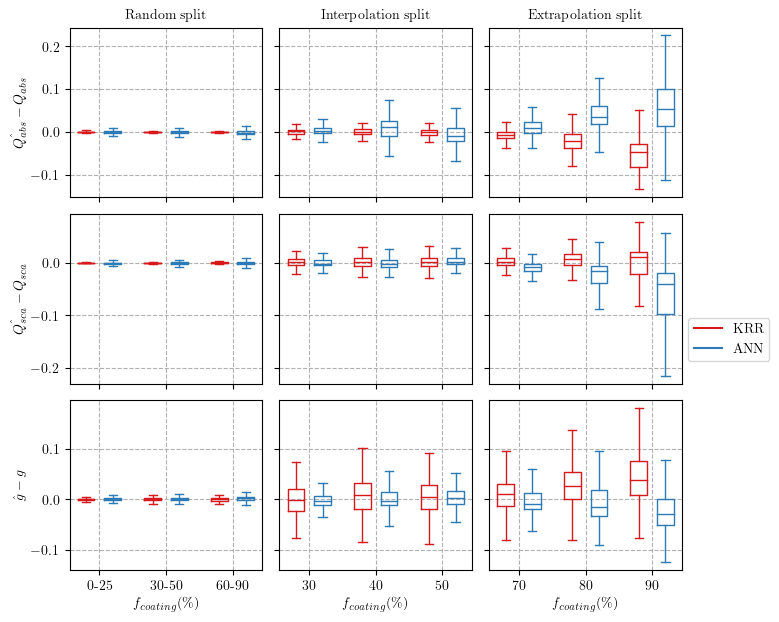

In [48]:
create_boxplots(df_random, df_extrapol, df_interpol, 'fraction_of_coating')